# Проект "Мэтчинг товаров"

## Описание

### Необходимо разработать алгоритм и модель, которые позволят:

- Найти N (CANDIDATES_NUM) похожих товаров из выборки "__А__" (base.csv) для выборки "__B__" (validation.csv)
- Сделать это за приемлемое время (точного времени нет, но пусть время не должно превышать 1000 секунд на поиск (MAX_SEARCH_TIME))
- Сделать это с максимизироваными метриками качества
- Проверить получившиеся товары на соответствие реальным похожим товаром из выборки "__С__" (validation_answer.csv)

### Метрики
- __accuracy@5__ (вычисляется для каждого объекта)
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

- __Accuracy Score__ для проверки общей точности предсказаний по всем классам
- __AUC-ROC__ – для проверки качества можели бинарной классификации (подошел/не подошел)

### Данные

- __Источник:__ https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
- `base.csv` : база данных всех товаров.
- `train.csv` : обучающая выборка, взятая из `base.csv`.
- `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
- `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`.

## Цели

- Максимизировать метрику accuracy@5
- Проверить модель на качество


## Задачи 

- Подготовка проекта
    - Импорт библиотек
    - Доболнительные переменные и функции
- Первичный обзор данных
- Исследовательский анализ даных
    - Поиск явных дубликатов
    - Изучение распределений, аномалий, выбросов
- Разделение признаков и целевого признака в данных
- Моделирование
    - Первоначальная оценка моделей
    - Проверка моделей на способность к улучшению
- Ранжирование (для проверки на метрики)
- Тестирование на модели Random Forest
- Общие выводы
- Рекоммендации по улучшению

# Работа

## Импорт библиотек

In [1]:
# %pip install phik
# %pip install faiss-cpu
# %pip install annoy

In [2]:
import phik
import os.path
import warnings
from itertools import chain, cycle
from time import perf_counter

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML

from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product

from annoy import AnnoyIndex
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


import gc

## Дополнительные переменные

In [3]:
# Установить флаг в False для работы с реальными данными
WORK_WITH_DOWNSAMPLED = False

# Коэффициент даунсэмплирования
WORK_WITH_DOWNSAMPLED_FRAC = 0.01

# Количество кластеров для faiss. Подобрано эмпирическим путем
FAISS_CLUSTERS_NUM = 50

# https://github.com/facebookresearch/faiss/wiki/The-index-factory
FAISS_EF_SEARCH = 32

# Количество ближайших опрашиваемых кластеров
# https://habr.com/ru/companies/avito/articles/488658/comments/#comment_21293102
FAISS_NPROBE = 64

# Суффикс для даунсэмплированых даных
DOWNSAMPLE_SUFFIX = "downsampled"

IQR = 1.5
Q1 = 0.25
Q3 = 0.75

RANDOM_STATE = 12345

# Количество ближайших соседей
K_N = 40

# Количество искомых кандидатов
CANDIDATES_NUM = 5

COLOR_BOLD = "\033[1m"
COLOR_END = "\033[0m"

COLOR_GREEN = "\033[92m"
COLOR_RED = "\033[91m"
COLOR_BLUE = "\e[1;94m"
COLOR_PURPLE = "\e[1;95m"
COLOR_CIAN = "\e[1;96m"

"red", "green", "blue", "purple", "cian"

COLORS_ARRAY = [
    {"plt": "red", "ansi": COLOR_RED},
    {"plt": "green", "ansi": COLOR_GREEN},
    {"plt": "blue", "ansi": COLOR_BLUE},
    {"plt": "purple", "ansi": COLOR_PURPLE},
    {"plt": "cian", "ansi": COLOR_CIAN},
]

warnings.filterwarnings("ignore")

NUMERIC_TYPES = ["int16", "int32", "int64", "float16", "float32", "float64"]
MB = 1024**2

## Вспомогательные функции

### Класс для даных

In [4]:
class Dataset:
    title = None
    name = None
    filename = None

    __work_with_downsampled = False
    __work_with_downsampled_frac = WORK_WITH_DOWNSAMPLED_FRAC

    __is_loaded = False
    __is_splitted = False
    __is_scaled = False
    __is_prepared = False

    __df: pd.DataFrame = None

    __random_state = 1234

    __data_dir = "data"
    __path = None
    __downsampled_path = None

    __target = None

    def __init__(
        self,
        title,
        name,
        filename,
        work_with_downsampled=False,
        work_with_downsampled_frac=WORK_WITH_DOWNSAMPLED_FRAC,
    ):
        self.title = title
        self.name = name
        self.filename = filename
        self.__work_with_downsampled = work_with_downsampled

    def prepare_data(self):

        if self.__is_prepared == True:
            print(
                f'Первичная подготовка данных датасета "{self.title} [{self.name}]" уже проведена.'
            )
            return

        print(f'Первичная подготовка данных для датасета "{self.title}" [{self.name}]:')
        self.__columns_to_lower()

        self.__memory_optimization()

        self.__is_prepared = True

    # Приводим имена полей к нижнему регистру
    def __columns_to_lower(self):
        self.__df.columns = self.__df.columns.str.lower()
        self.__df = self.__df.rename_axis('id', axis=0)

        # target.rename_axis('id')

        print("Имена колонок приведены к нижнему регистру")


    # Получаем путь до датасета
    def __get_dataset_path(self, is_downsampled_path=False):
        downsampled_sfx = ""

        if is_downsampled_path:
            downsampled_sfx = f"_{DOWNSAMPLE_SUFFIX}"

        path = f"{self.__data_dir}/{self.filename}{downsampled_sfx}.csv"

        return path

    # Загружаем датасет
    def load(self, index_col=None):

        if self.__is_loaded == True:
            print(f'Датасет "{self.title} [{self.name}]" уже загружен.')
            return

        path = self.__get_dataset_path()

        if self.__work_with_downsampled == True:
            downsampled_path = self.__get_dataset_path(is_downsampled_path=True)

            if os.path.isfile(downsampled_path):

                print(
                    f'Есть даунсемплированый файл для {self.title} [{self.name}]: "{downsampled_path}"'
                )

                try:
                    self.__df = pd.read_csv(downsampled_path, index_col=index_col)
                    self.__is_loaded = True
                    print(
                        f'Датасет "{self.title} [{self.name}]" успешно загружен. Путь: "{downsampled_path}"'
                    )
                except Exception as err:
                    print(
                        f'Ошибка загрузки датасета "{self.title}" по пути: "{downsampled_path}":'
                    )
                    print(err)

            else:

                try:
                    df = pd.read_csv(path, index_col=index_col)
                    self.__df = df.sample(frac=self.__work_with_downsampled_frac)
                    print(
                        f'Датасет "{self.title} [{self.name}]" успешно загружен. Путь: "{downsampled_path}"'
                    )
                    self.__is_loaded = True

                    try:
                        self.__df.to_csv(downsampled_path)
                        print(
                            f'Датасет "{self.title} [{self.name}]" успешно даунсэмплирован и сохранен по пути: "{downsampled_path}"'
                        )
                    except Exception as err:
                        print(
                            f'Ошибка даунсэмплирования датасета "{self.title}" по пути: "{downsampled_path}":'
                        )
                        print(err)
                except Exception as err:
                    print(f'Ошибка загрузки датасета "{self.title}" по пути: "{path}":')
                    print(err)
            return

        else:
            try:
                self.__df = pd.read_csv(path, index_col=index_col)
                self.__is_loaded = True
                print(
                    f'Датасет "{self.title} [{self.name}]" успешно загружен. Путь: "{path}"'
                )
            except Exception as err:
                print(f'Ошибка загрузки датасета "{self.title}" по пути: "{path}":')
                print(err)

    def get_downsampled_df(self, frac=0.1):
        if len(self.__df) != 0:
            return self.__df.sample(frac=frac, random_state=self.__random_state)

        return None

    def get_df(self):
        return self.__df

    def show_info(self):
        print(f'{COLOR_BOLD}INFO: Датасет "{self.title} [{self.name}]"{COLOR_END}')
        display(self.__df.info())

    def show_head(self, items=5):
        print(f'{COLOR_BOLD}HEAD: Датасет "{self.title} [{self.name}]"{COLOR_END}')
        display(self.__df.head(items))

    def __handle_columns(self):
        self.__df.columns = self.__df.columns.str.lower()
        self.__df.set_index("id", inplace=True)

    def __memory_optimization(self):
        before_size = round(self.__df.memory_usage().sum() / MB, 3)

        for col in self.__df.columns:

            col_type = self.__df[col].dtypes

            if col_type in NUMERIC_TYPES:

                col_min = self.__df[col].min()
                col_max = self.__df[col].max()

                if str(col_type).startswith("int"):

                    if (
                        col_min > np.iinfo(np.int8).min
                        and col_max < np.iinfo(np.int8).max
                    ):
                        df[col] = df[col].astype(np.int8)
                    elif (
                        col_min > np.iinfo(np.int16).min
                        and col_max < np.iinfo(np.int16).max
                    ):
                        self.__df[col] = self.__df[col].astype(np.int16)
                    elif (
                        col_min > np.iinfo(np.int32).min
                        and col_max < np.iinfo(np.int32).max
                    ):
                        self.__df[col] = self.__df[col].astype(np.int32)
                    elif (
                        col_min > np.iinfo(np.int64).min
                        and col_max < np.iinfo(np.int64).max
                    ):
                        self.__df[col] = self.__df[col].astype(np.int64)
                else:
                    if (
                        col_min > np.finfo(np.float32).min
                        and col_max < np.finfo(np.float32).max
                    ):
                        self.__df[col] = self.__df[col].astype(np.float32)
                    else:
                        self.__df[col] = self.__df[col].astype(np.float64)

        after_size = round(self.__df.memory_usage().sum() / MB, 3)

        print(f"Размер до/после оптимизации (МБ): {before_size}/{after_size}")
        print()

    def target_feature_splitting(self, target_col_name):
        if self.__is_splitted == True:
            return

        self.__target = self.__df[target_col_name.lower()]
        
        self.__df.drop(target_col_name.lower(), axis=1, inplace=True)
        self.__is_splitted = True

        display(self.__target)

        print(
            f'Целевой признак [{target_col_name}] датасета "{self.title}" [{self.name}]:'
        )
        display(self.__target.head())
        print()
        print(f'Признаки датасета "{self.title}" [{self.name}]:')
        display(self.__df.head())

    def get_target(self):
        return self.__target

    def set_df_scaled(self, df_scaled):
        if self.__is_scaled == True:
            return
        
        df = pd.DataFrame(
            df_scaled, columns=self.__df.columns, index=self.__df.index
        )
        self.__df = df
        
        self.__is_scaled = True
        
    def drop_cols(self, cols):
        self.__df = self.__df.drop(cols, axis=1)
        

### Загрузка данных

In [5]:
%%time
base_d = Dataset(
    title="Анонимизированный набор товаров",
    name="base",
    filename="base",
    work_with_downsampled=WORK_WITH_DOWNSAMPLED,
)


train_d = Dataset(
    title="Обучающий датасет",
    name="train",
    filename="train",
    work_with_downsampled=WORK_WITH_DOWNSAMPLED,
)

validation_d = Dataset(
    title="Датасет с товарами (для поиска)",
    name="validation",
    filename="validation",
    work_with_downsampled=WORK_WITH_DOWNSAMPLED,
)

validation_answer_d = Dataset(
    title='Правильные ответы для "validation"',
    name="validation_answer",
    filename="validation_answer",
    work_with_downsampled=False,
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [6]:
%%time
base_d.load(index_col=0)
base_d.prepare_data()

train_d.load(index_col=0)
train_d.prepare_data()

validation_d.load(index_col=0)
validation_d.prepare_data()

validation_answer_d.load(index_col=0)
validation_answer_d.prepare_data()

Датасет "Анонимизированный набор товаров [base]" успешно загружен. Путь: "data/base.csv"
Первичная подготовка данных для датасета "Анонимизированный набор товаров" [base]:
Имена колонок приведены к нижнему регистру
Размер до/после оптимизации (МБ): 1625.245/823.754

Датасет "Обучающий датасет [train]" успешно загружен. Путь: "data/train.csv"
Первичная подготовка данных для датасета "Обучающий датасет" [train]:
Имена колонок приведены к нижнему регистру
Размер до/после оптимизации (МБ): 56.458/28.992

Датасет "Датасет с товарами (для поиска) [validation]" успешно загружен. Путь: "data/validation.csv"
Первичная подготовка данных для датасета "Датасет с товарами (для поиска)" [validation]:
Имена колонок приведены к нижнему регистру
Размер до/после оптимизации (МБ): 55.695/28.229

Датасет "Правильные ответы для "validation" [validation_answer]" успешно загружен. Путь: "data/validation_answer.csv"
Первичная подготовка данных для датасета "Правильные ответы для "validation"" [validation_answ

### Класс для основного проекта

In [7]:
class Project:
    datasets = []

    __scaler = RobustScaler()

    def __print_separator(self):
        print("-------------------------------")

    def add_datasets(self, datasets=[]):
        self.datasets = datasets

    def get_dataset(self, name):
        dataset = None
        for d in self.datasets:
            if d.name == name:
                dataset = d
                break

        return d

    def show_all_heads(self):
        for d in self.datasets:
            self.__print_separator()
            d.show_head()

    def show_all_infos(self):
        for d in self.datasets:
            self.__print_separator()
            d.show_info()

    def hist_matrix(self, datasets_names=[]):

        x = 6
        y = 12

        markers = ["o", "+", "x", "*", "d"]

        fig, axs = plt.subplots(y, x, figsize=(x * 4, y * 4))

        legends = [
            "",
            "",
            "",
            "",
            "",
            "",
            "",
        ]

        jx = 0  # накопитель
        for i in range(y):

            for j in range(x):
                column = str(i + j + jx)

                for idx, name in enumerate(datasets_names):
                    datasetInstance = self.get_dataset(name)
                    dataset = datasetInstance.get_df()
                    d = dataset[column].value_counts(normalize=True).sort_index() * 100

                    marker = markers[idx]
                    color_map = COLORS_ARRAY[idx]

                    color_plt = color_map["plt"]
                    color_ansi = color_map["ansi"]

                    legend_item = f"{COLOR_BOLD}{datasetInstance.title}:{COLOR_END} {color_ansi} {marker} {COLOR_END}"
                    legends[idx] = legend_item

                    axs[i, j].plot(
                        d,
                        marker=marker,
                        linestyle="",
                        color=color_plt,
                        label=datasetInstance.title,
                    )
                    axs[i, j].set_title("Прзнак №" + column + " (значения)")
            jx += 5

        for legend_item in legends:
            if legend_item != "":
                print(legend_item)

        plt.show()

    def calculate_emissions_percenage(self, col: pd.Series):

        current_iqr = col.quantile(Q3) - col.quantile(Q1)
        upper = col.quantile(Q3) + IQR * current_iqr
        lower = col.quantile(0.25) - IQR * current_iqr

        # Если усы границы экстремумы, приравняем их.
        if upper >= col.max():
            upper = col.max()
        if lower <= col.min():
            lower = col.min()
        else:
            pass

        coll_upper_count = col[col > upper].count()
        coll_lower_count = col[col < lower].count()

        emissions_percentage = (coll_upper_count + coll_lower_count) / len(col)

        return emissions_percentage

    def hist_diagrams(self, dataset_name, frac=None):
        dataset = self.get_dataset(dataset_name)

        df = dataset.get_df()

        sample_title_sfx = ""

        if frac != None:
            df = dataset.get_downsampled_df(frac=frac)

            sample_title_sfx = f"Сэмплирование: {frac:.0%}"

        axs = df.hist(figsize=[20, 20], bins=50)

        for ax, col in zip(axs.flatten(), df.columns[1:]):
            title = f'Признак "{col}".\n'

            emissions_percenage = self.calculate_emissions_percenage(df[col])
            formatted_percentae = f"{emissions_percenage:.1%}"
            title = f"{title}Выбросов: {formatted_percentae}"

            ax.set_title(title)

        plt.suptitle(
            f'Гистограммы для признаков датасета "{dataset.title}". {sample_title_sfx}',
            y=0.99,
            fontsize=16,
        )
        plt.tight_layout()
        plt.show()

    def range_diagrams(self, dataset_name, frac=None):
        dataset = self.get_dataset(dataset_name)
        df = dataset.get_df()

        sample_title_sfx = ""

        if frac != None:
            df = dataset.get_downsampled_df(frac=frac)

            sample_title_sfx = f"Сэмплирование: {frac:.0%}"

        df.plot(kind="box", grid=True, figsize=[20, 8])

        plt.title(
            f'Гистограммы для признаков датасета "{dataset.title}". {sample_title_sfx}',
            fontsize=16,
        )
        plt.tight_layout()
        plt.show()

    def pirson_corr_matrix(self, dataset_name, frac=None):
        dataset = self.get_dataset(dataset_name)
        df = dataset.get_df()

        sample_title_sfx = ""

        if frac != None:
            df = dataset.get_downsampled_df(frac=frac)
            sample_title_sfx = f"Сэмплирование: {frac:.0%}"

        sns.set(rc={"figure.figsize": (13, 10)})
        sns.heatmap(df.loc[:, df.columns != "Id"].corr(), square=True)
        plt.title(
            f'Матрица коэффициентов корреляций Пирсона для датасета: "{dataset.title}". {sample_title_sfx}'
        )
        plt.show()

    def phi_corr_matrix(self, dataset_name, frac=None):
        dataset = self.get_dataset(dataset_name)
        df = dataset.get_df()

        sample_title_sfx = ""

        if frac != None:
            df = dataset.get_downsampled_df(frac=frac)
            sample_title_sfx = f"Сэмплирование: {frac:.0%}"

        f, ax = plt.subplots(figsize=(13, 10))
        sns.heatmap(
            df.loc[:, df.columns != "Id"].phik_matrix(interval_cols=df.columns[1:])
        )

        plt.title(
            f'Матрица коэффициентов корреляций Фи (Phi) для датасета: "{dataset.title}". {sample_title_sfx}'
        )
        plt.show()
        

    def scaler_fit(self, dataset_name):
        dataset = self.get_dataset(dataset_name)

        df = dataset.get_df()
        
        self.__scaler.fit(df)

    def scaler_transform(self, dataset_name):
        dataset = self.get_dataset(dataset_name)
        df = dataset.get_df()
        
        df = self.__scaler.transform(df)
        dataset.set_df_scaled(df)

    def check_duplicates(self):
        for dataset_class in self.datasets:
            
            title = dataset_class.title
            raw = dataset_class.get_df()
        
            duplicates = raw.duplicated().sum().sum()
            missing_data = raw.isna().sum().sum()
        
            print('---------------------------------------------')
            print(f'{COLOR_BOLD}Датасет: "{title}"{COLOR_END}')
            print(f'Количество дубликатов: {duplicates}')
            print(f'Количество пропусков:  {missing_data}')

### Инициализация проекта

In [8]:
project = Project()

In [9]:
project.add_datasets([base_d, train_d, validation_d, validation_answer_d])

## Обзор данных

In [10]:
project.show_all_heads()

-------------------------------
HEAD: Датасет "Анонимизированный набор товаров [base]"


0          1          2           3           4           5  \
id                                                                             
0-base -115.083893  11.152912 -64.426758 -118.880890  216.482437 -104.698059   
1-base  -34.562202  13.332763 -69.787613 -166.533478   57.680607  -86.098373   
2-base  -54.233746   6.379371 -29.210136 -133.413834  150.895828  -99.435326   
3-base  -87.520126   4.037884 -87.803032 -185.067627   76.369537  -58.985165   
4-base  -72.743851   6.522048  43.671265 -140.608032    5.820023 -112.074081   

                 6          7           8           9  ...          62  \
id                                                     ...               
0-base -469.070587  44.348083  120.915344  181.449707  ...  -42.808693   
1-base  -85.076668 -35.637436  119.718636  195.234192  ... -117.767525   
2-base   52.554794  62.381706  128.951447  164.381470  ...  -76.397797   
3-base -383.182831 -33.611237  122.031914  136.233582  ...  -70.647942   
4-base -397.711273  45.182499  122.167183  112.119064  ...  -57.199104   

               63          64          65         66         67          68  \
id                                                                            
0-base  38.800827 -151.762177  -74.389091  63.666340  -4.703861   92.933609   
1-base  41.099998 -157.829407  -94.446808  68.202110  24.346846  179.937927   
2-base  46.011803 -207.144424  127.325569  65.566177  66.325684   81.073486   
3-base  -6.358921 -147.201050  -37.692749  66.202888 -20.566910  137.206940   
4-base  56.642403 -159.351837   85.944725  66.766319  -2.505783   65.315285   

                69           70         71  
id                                          
0-base  115.269188  -112.756638 -60.830353  
1-base  116.834000   -84.888939 -59.524609  
2-base  116.594154 -1074.464844 -32.527206  
3-base  117.474098 -1074.464844 -72.915489  
4-base  135.051590 -1074.464844   0.319401  

[5 rows x 72 columns]

-------------------------------
HEAD: Датасет "Обучающий датасет [train]"


0          1           2           3           4           5  \
id                                                                              
0-query -53.882748  17.971436  -42.117104 -183.936676  187.517487  -87.144928   
1-query -87.776367   6.806268  -32.054546 -177.260391  120.803329  -83.810593   
2-query -49.979565   3.841486 -116.118591 -180.401978  190.128433  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.011360   94.652840 -109.255409   
4-query -79.632126  14.442886  -58.903397 -147.052536   57.127068  -16.239529   

                  6          7           8           9  ...         63  \
id                                                      ...              
0-query -347.360596  38.307602  109.085564   30.413513  ...  70.107361   
1-query  -94.572746 -78.433090  124.915901  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607819  ...  78.039764   
3-query -775.150146  79.186523  124.003098  242.650650  ...  44.515266   
4-query -321.317963  45.984676  125.941284  103.392670  ...  45.028912   

                 64          65         66          67          68  \
id                                                                   
0-query -155.802567 -101.965942  65.903793   34.457500   62.642094   
1-query -151.697708   -1.638704  68.170876   25.096191   89.974976   
2-query -169.146194   82.144188  66.008217   18.400496  212.409729   
3-query -145.416748   93.990982  64.131348  106.061920   83.178757   
4-query -196.092072 -117.626335  66.926224   42.456169   77.621765   

                 69           70         71        target  
id                                                         
0-query  134.763596  -415.750244 -25.958572   675816-base  
1-query  130.589630 -1035.092163 -51.276833   366656-base  
2-query  121.931473 -1074.464844 -22.547178  1447819-base  
3-query  118.277725 -1074.464844 -19.902788  1472602-base  
4-query   92.479927 -1074.464844 -21.149351   717819-base  

[5 rows x 73 columns]

-------------------------------
HEAD: Датасет "Датасет с товарами (для поиска) [validation]"


0          1          2           3           4  \
id                                                                      
100000-query -57.372734   3.597752 -13.213642 -125.926788  110.745941   
100001-query -53.758705  12.790300 -43.268543 -134.417618  114.449913   
100002-query -64.175095  -3.980927  -7.679249 -170.160934   96.446159   
100003-query -99.286858  16.123936   9.837166 -148.060440   83.697083   
100004-query -79.532921  -0.364173 -16.027431 -170.884949  165.453918   

                       5           6           7           8           9  ...  \
id                                                                        ...   
100000-query  -81.279594 -461.003174  139.815720  112.880981   75.215752  ...   
100001-query  -90.520126 -759.626038   63.995087  127.117905   53.128998  ...   
100002-query  -62.377739 -759.626038   87.477554  131.270111  168.920319  ...   
100003-query -133.729721   58.576405  -19.046659  115.042404   75.206734  ...   
100004-query  -28.291668   33.931934   34.411217  128.903976  102.086914  ...   

                      62         63          64          65         66  \
id                                                                       
100000-query  -75.513023  52.830902 -143.439453   59.051933  69.282242   
100001-query  -79.441833  29.185436 -168.605896  -82.872444  70.765602   
100002-query -134.795410  37.368729 -159.662308 -119.232727  67.710442   
100003-query  -77.236107  44.100494 -132.530121 -106.318985  70.883957   
100004-query -123.770248  45.635944 -134.258926   13.735359  70.617630   

                     67          68          69           70          71  
id                                                                        
100000-query  61.927513  111.592529  115.140656 -1099.130493 -117.079361  
100001-query -65.975952   97.077164  123.391640  -744.442322  -25.009319  
100002-query  86.002060  137.636414  141.081635  -294.052277  -70.969604  
100003-query  23.577892  133.183960  143.252945  -799.363647  -89.392670  
100004-query  15.332115  154.568115  101.700638 -1171.892334 -125.307892  

[5 rows x 72 columns]

-------------------------------
HEAD: Датасет "Правильные ответы для "validation" [validation_answer]"


expected
id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

### Общая информация датасетов

In [11]:
project.show_all_infos()

-------------------------------
INFO: Датасет "Анонимизированный набор товаров [base]"
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float

None

-------------------------------
INFO: Датасет "Обучающий датасет [train]"
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19    

None

-------------------------------
INFO: Датасет "Датасет с товарами (для поиска) [validation]"
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-

None

-------------------------------
INFO: Датасет "Правильные ответы для "validation" [validation_answer]"
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

### Вывод по датасетам

- Типы датасетов – корректные
- Пропусков нет

## Исследовательский анализ данных [EDA]

### Поиск явных дубликатов и пропущенных данных

In [12]:
project.check_duplicates()

---------------------------------------------
Датасет: "Анонимизированный набор товаров"
Количество дубликатов: 0
Количество пропусков:  0
---------------------------------------------
Датасет: "Обучающий датасет"
Количество дубликатов: 0
Количество пропусков:  0
---------------------------------------------
Датасет: "Датасет с товарами (для поиска)"
Количество дубликатов: 0
Количество пропусков:  0
---------------------------------------------
Датасет: "Правильные ответы для "validation""
Количество дубликатов: 8498
Количество пропусков:  0


Явных дубликатов нет.
Поиск неявных дубликатов не представляется восможным в виду незнания реальных контекстов полей и данных

### Изучение распределений данных, аномалий и выбросов

#### Гистограммы распределений всех датасетов

Выведем гистограммы распределений всех полей всех датасетов на соответствующих данных для того чтобы оценить схожесть данных

Анонимизированный набор товаров:  o 
Обучающий датасет:  + 
Датасет с товарами (для поиска): \e x 


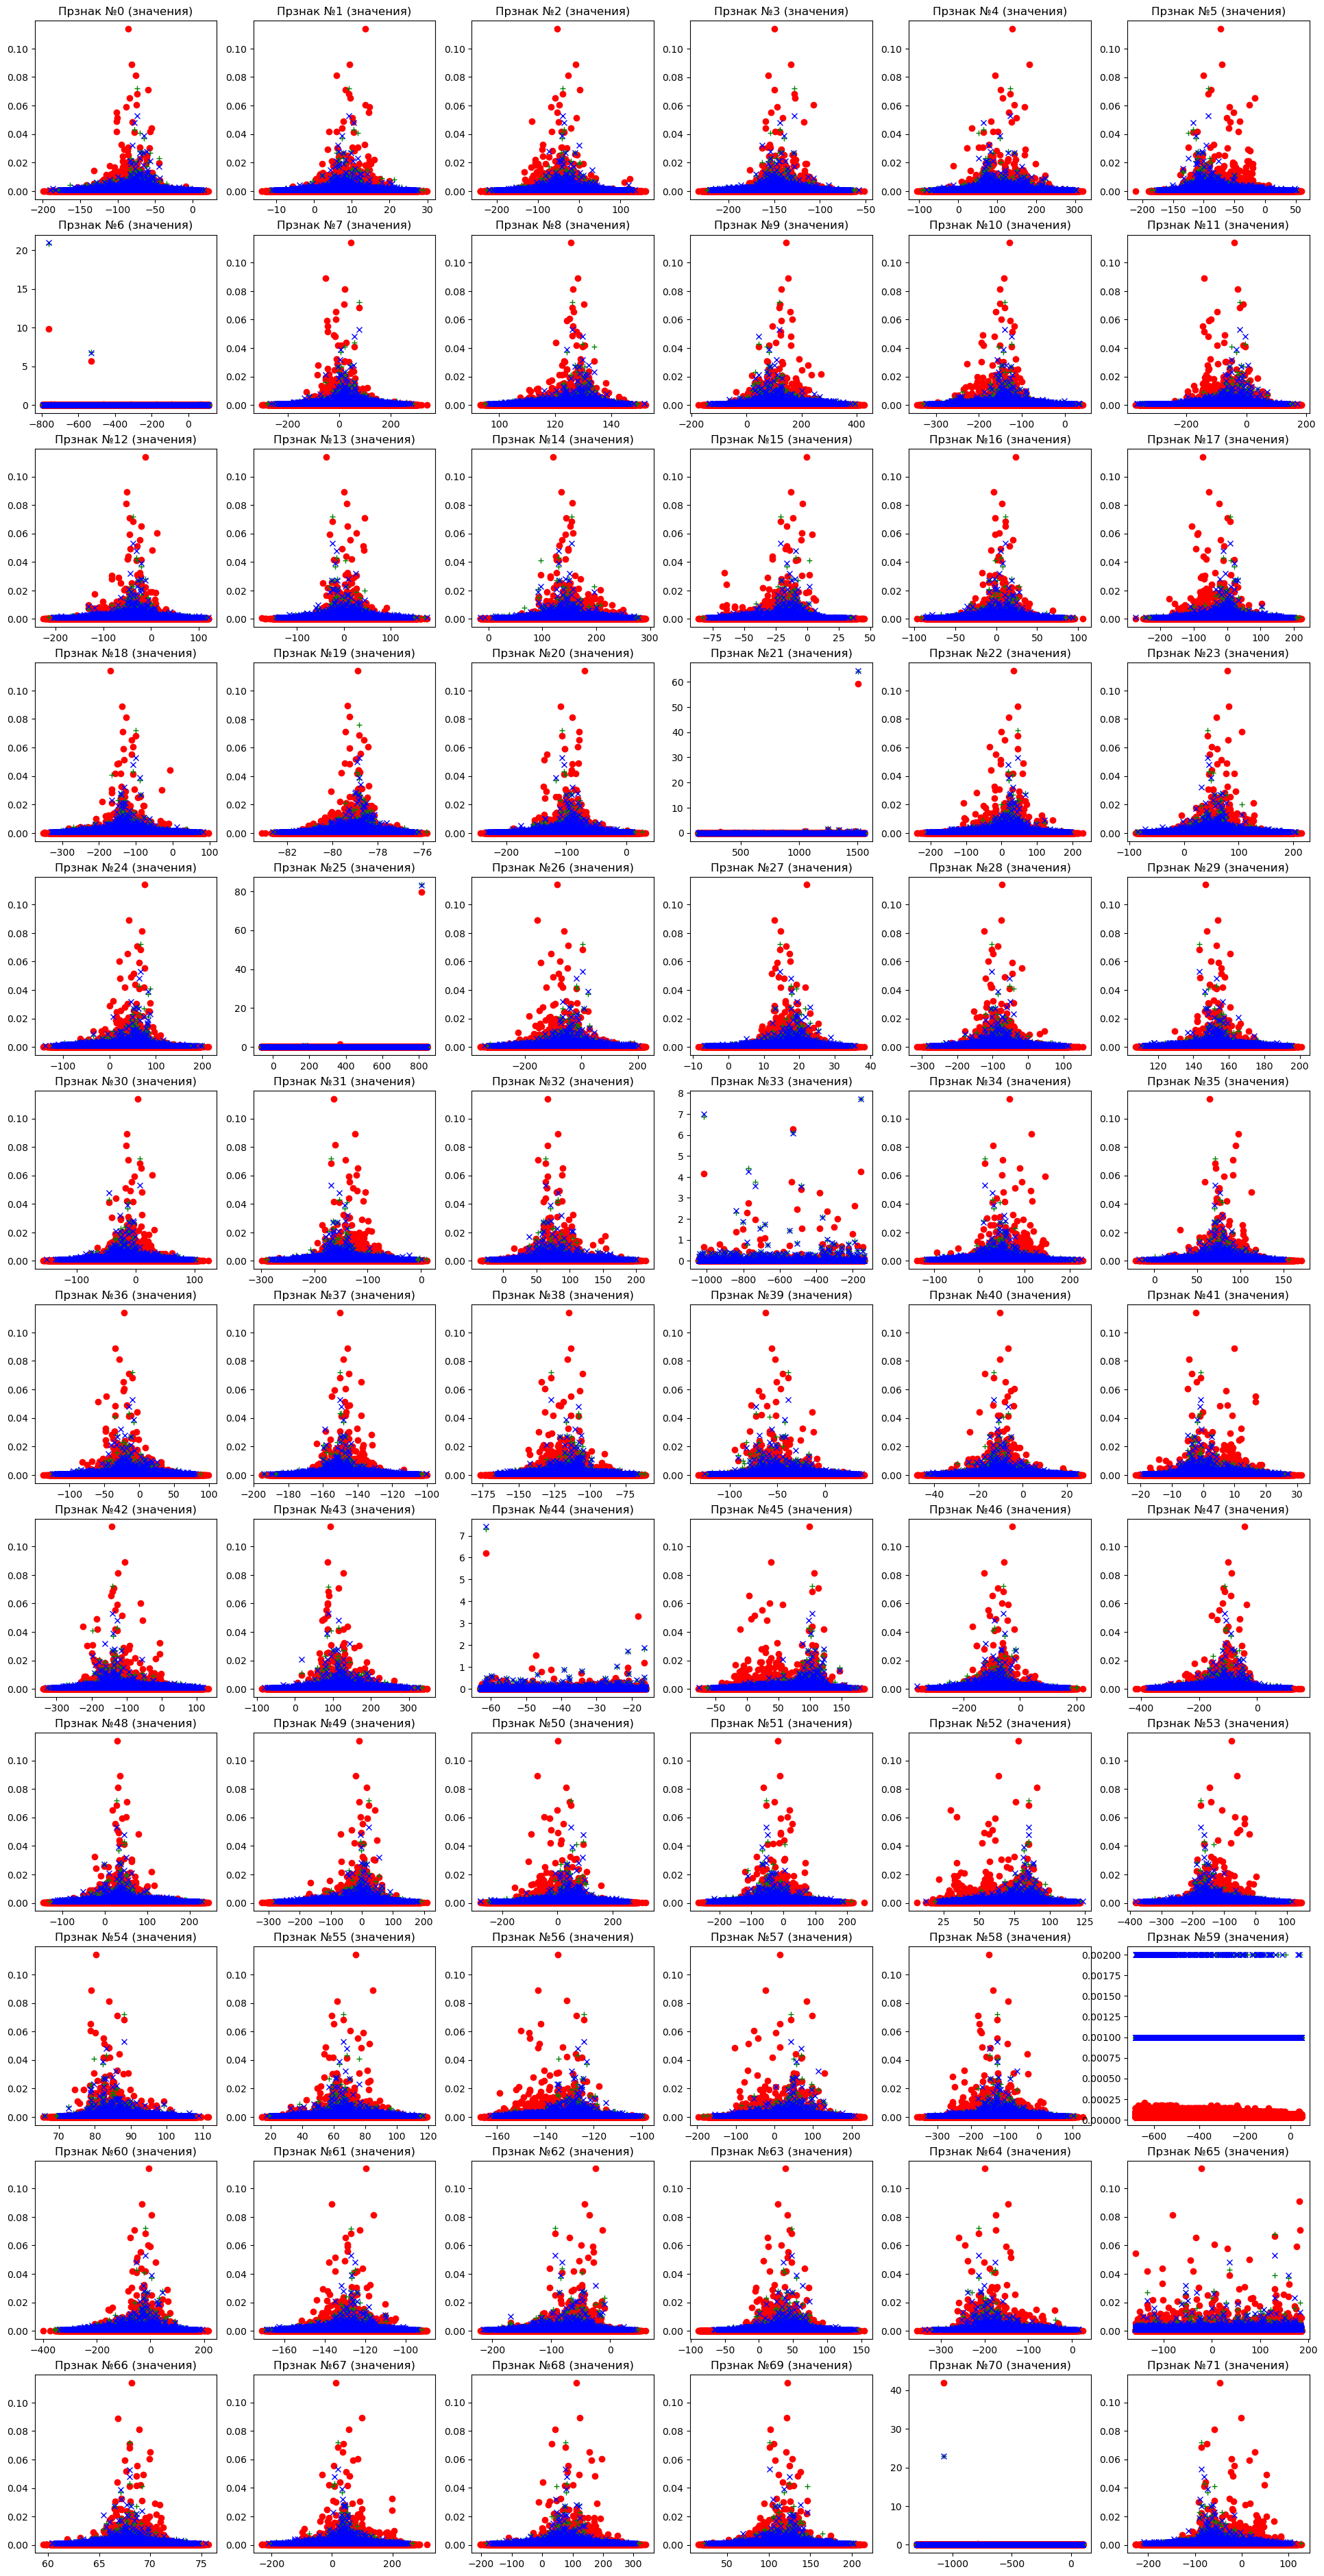

In [13]:
project.hist_matrix(datasets_names=['base', 'train', 'validation'])

#### Гистограммы распределений признаков датасета [base]

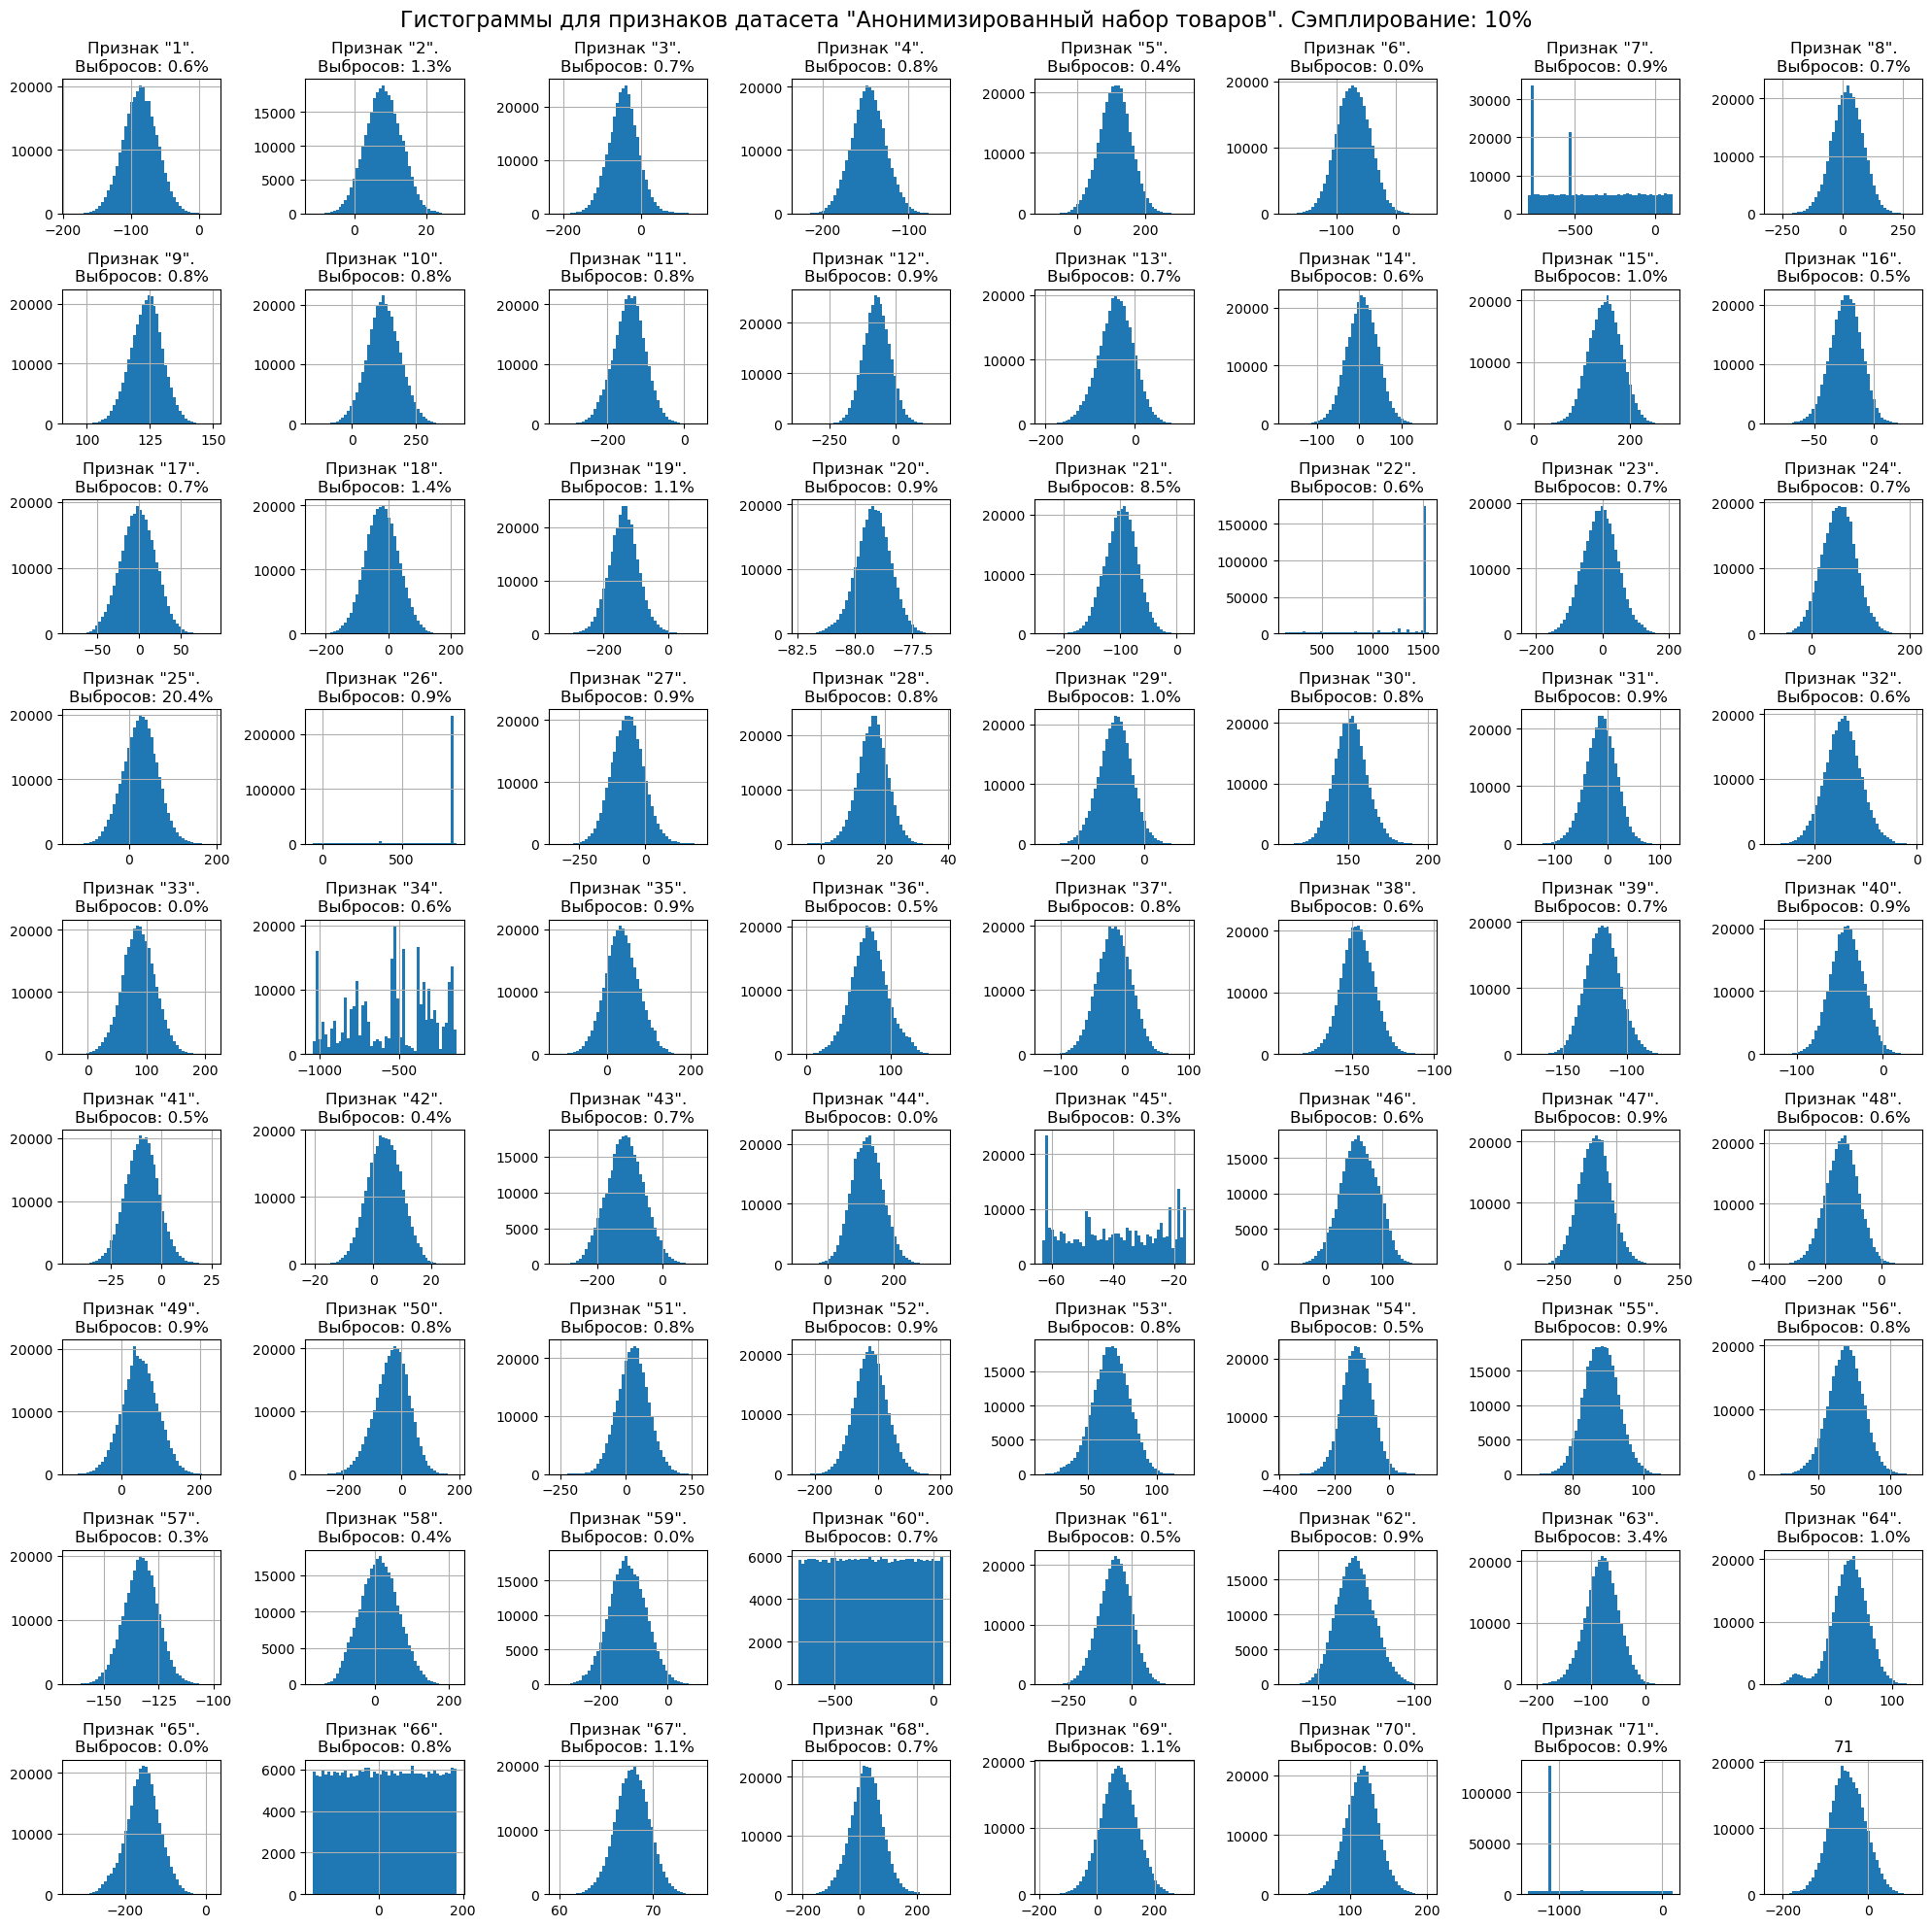

In [14]:
project.hist_diagrams(dataset_name='base', frac=0.1)

#### Диаграммы размаха для данных из датасета [base]

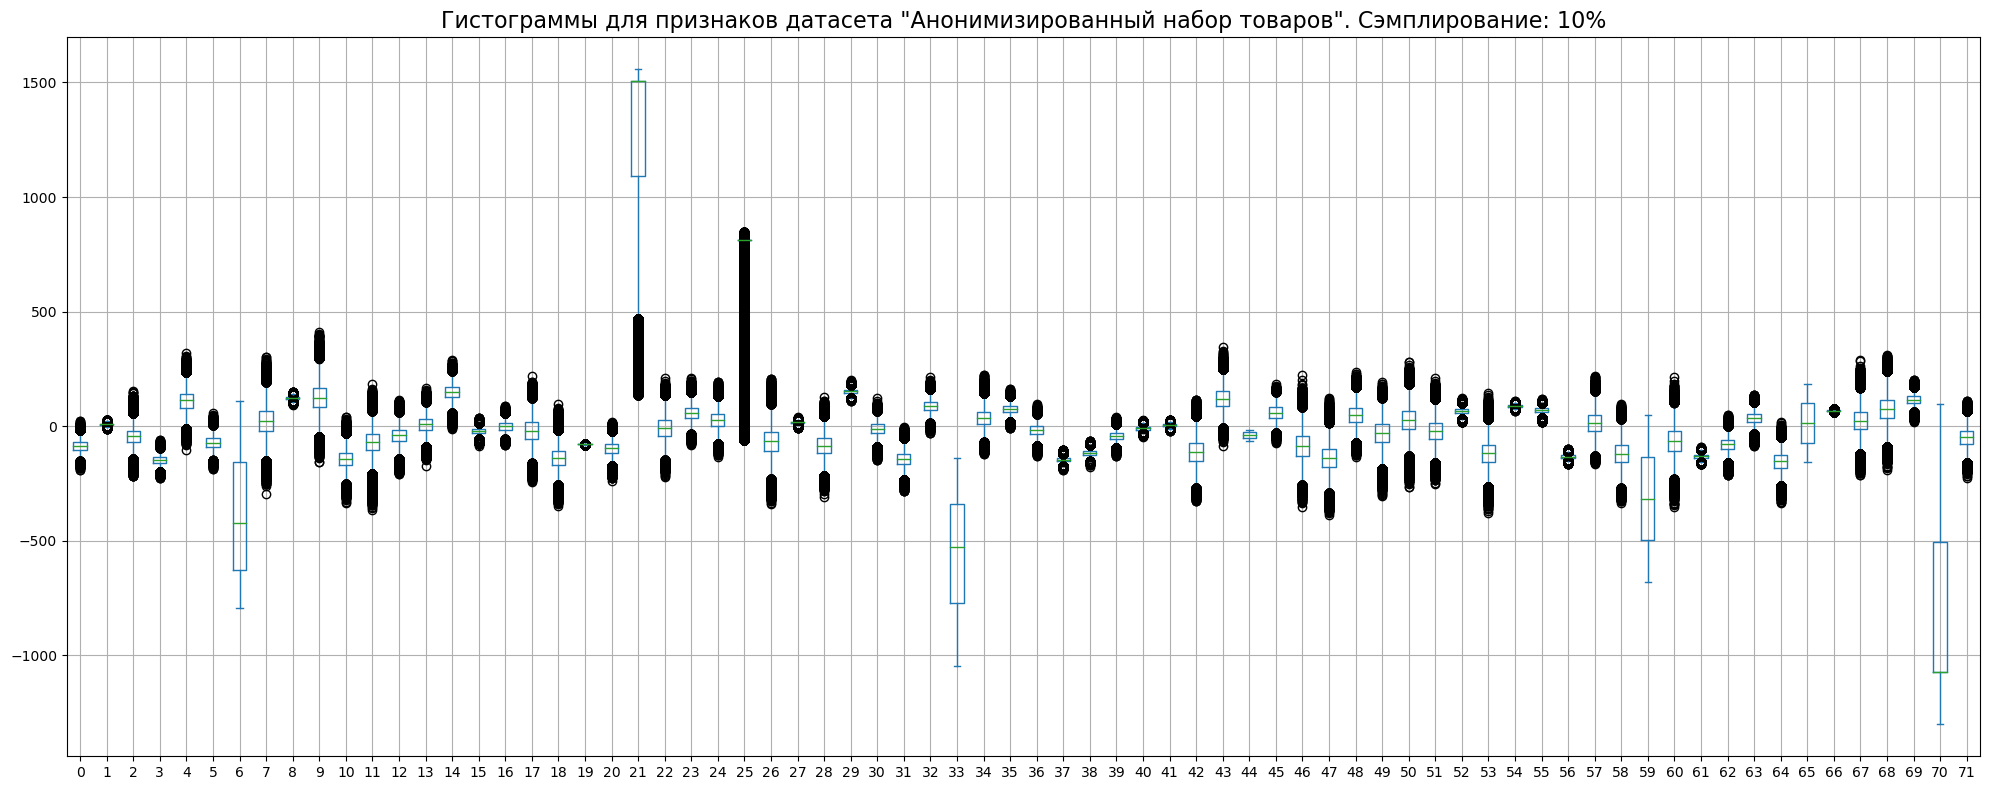

In [15]:
project.range_diagrams(dataset_name='base', frac=0.1)

#### Матрица корреляций признаков по методу Пирсона для данных из датасета [base]

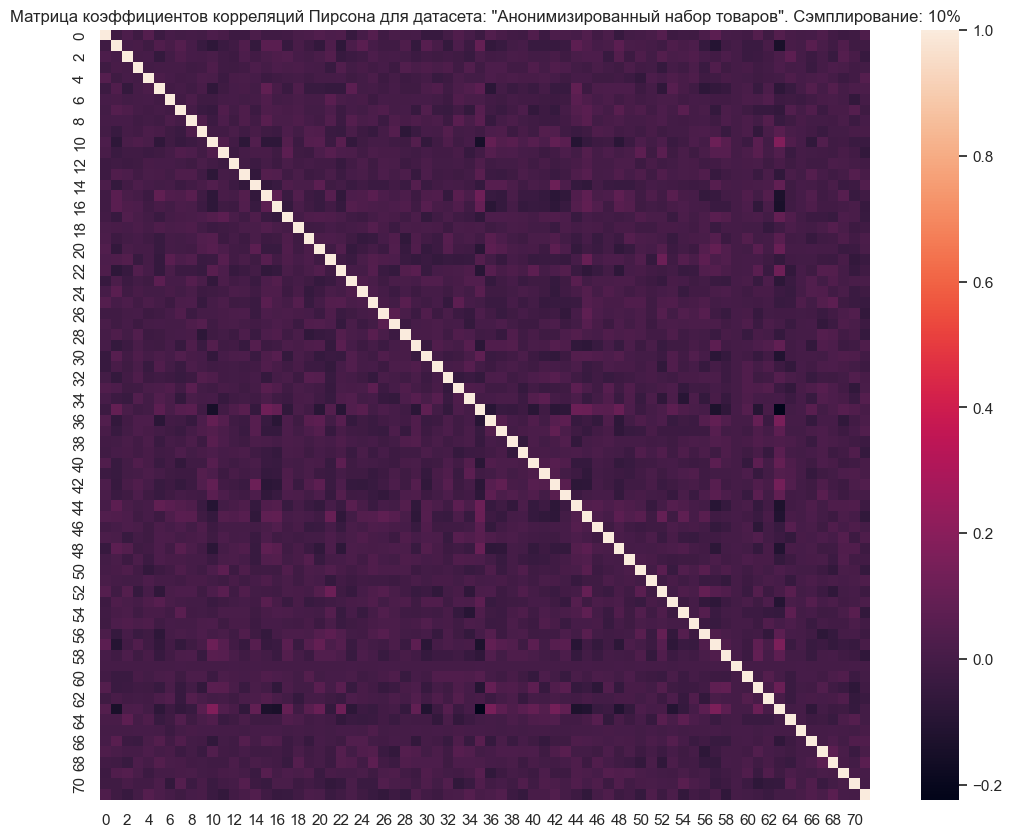

In [16]:
project.pirson_corr_matrix(dataset_name='base', frac=0.1)

#### Матрица корреляций признаков по методу Фи (Phi) для данных из датасета [base]

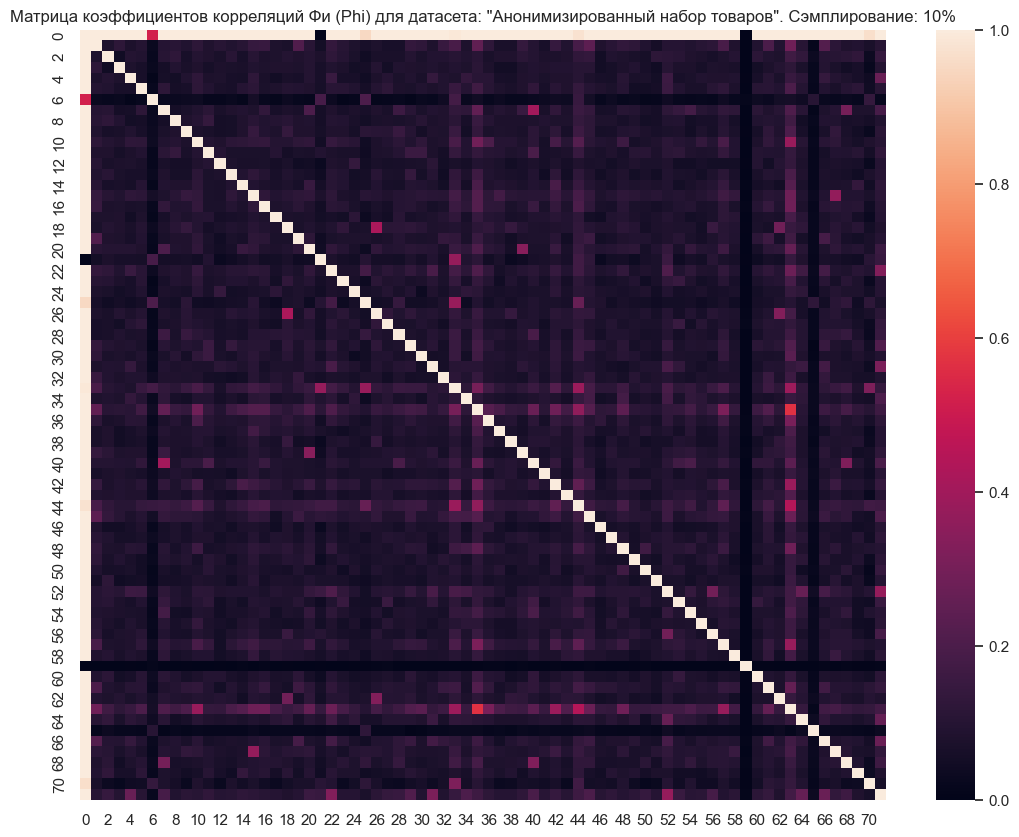

In [17]:
project.phi_corr_matrix(dataset_name='base', frac=0.1)

#### Выводы по качеству данных

- Соответствующие признаки в данных в датасетах: 'base', 'train', 'validation' распределены примерно одинаково
- Распределения нормальные почти во всех полях, кроме полей: '6', '21', '25', '33', '44', '59', '65', '70' (возможно это категориальные значения). В любом случае проверим их влияние на качество модели и лишние удалим
- Данные миеют слабую корреляцию и ориетироваться на нее сейчас не стоит (нельзя уменьшить размерность путем слияния коррелирующих значений)
- Особых аномалий в нормально-распределенных полях нет

## Разделение тренировочной выборки на target/features

In [18]:
train_d.target_feature_splitting(target_col_name="Target")

id
0-query         675816-base
1-query         366656-base
2-query        1447819-base
3-query        1472602-base
4-query         717819-base
                   ...     
99995-query     811868-base
99996-query    1460772-base
99997-query    2366140-base
99998-query       9252-base
99999-query    2769109-base
Name: target, Length: 100000, dtype: object

Целевой признак [Target] датасета "Обучающий датасет" [train]:


id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: target, dtype: object


Признаки датасета "Обучающий датасет" [train]:


0          1           2           3           4           5  \
id                                                                              
0-query -53.882748  17.971436  -42.117104 -183.936676  187.517487  -87.144928   
1-query -87.776367   6.806268  -32.054546 -177.260391  120.803329  -83.810593   
2-query -49.979565   3.841486 -116.118591 -180.401978  190.128433  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.011360   94.652840 -109.255409   
4-query -79.632126  14.442886  -58.903397 -147.052536   57.127068  -16.239529   

                  6          7           8           9  ...          62  \
id                                                      ...               
0-query -347.360596  38.307602  109.085564   30.413513  ... -105.427818   
1-query  -94.572746 -78.433090  124.915901  140.331070  ...  -40.812233   
2-query   26.943937 -30.447489  125.771164  211.607819  ...  -52.031662   
3-query -775.150146  79.186523  124.003098  242.650650  ...  -61.567047   
4-query -321.317963  45.984676  125.941284  103.392670  ...  -68.770599   

                63          64          65         66          67          68  \
id                                                                              
0-query  70.107361 -155.802567 -101.965942  65.903793   34.457500   62.642094   
1-query   4.669178 -151.697708   -1.638704  68.170876   25.096191   89.974976   
2-query  78.039764 -169.146194   82.144188  66.008217   18.400496  212.409729   
3-query  44.515266 -145.416748   93.990982  64.131348  106.061920   83.178757   
4-query  45.028912 -196.092072 -117.626335  66.926224   42.456169   77.621765   

                 69           70         71  
id                                           
0-query  134.763596  -415.750244 -25.958572  
1-query  130.589630 -1035.092163 -51.276833  
2-query  121.931473 -1074.464844 -22.547178  
3-query  118.277725 -1074.464844 -19.902788  
4-query   92.479927 -1074.464844 -21.149351  

[5 rows x 72 columns]

## Моделирование

In [19]:
class Modeling:
    
    project: None

    __dataset_class = None
    __train_dataset_class = None
    
    __vec_len = None
    base_index = None
    
    __dataset_name = ''
    __dataset_train_name = ''
    
    anomal_features_cols = []

    best_faiss_index = None
    best_distance = {}
    best_idx = {}

    def __init__(self, project, dataset_name='base', dataset_train_name='train'):
        self.project = project
        self.__dataset_name = dataset_name
        self.__dataset_train_name = dataset_train_name
        
    def calculate_accuracy_n(self, target, predict):
        acc = 0
        for target_item, candidates in zip(target, predict):
            acc += int(target_item in [self.base_index[number] for number in candidates])

        return round((100 * acc / len(predict)), 3)
         
    def __get_dfs(self, dropped_cols=None):
        # Берем датафреймы (основной и обучающий)
        
        dataset_class = self.project.get_dataset(self.__dataset_name)
        df = dataset_class.get_df()
        
        self.base_index = {k: v for k, v in enumerate(df.index.to_list())}
        
        dataset_train_class = self.project.get_dataset(self.__dataset_train_name)
        df_train = dataset_train_class.get_df()
        
        if dropped_cols != None:
            df = df.drop(dropped_cols, axis=1)
            df_train = df_train.drop(dropped_cols, axis=1)
            
        self.__vec_len = df.shape[1]
        
        train_size = int(df.shape[0] * .1)
            
        return df, df_train, train_size
    
    def __end_perf(self, start):
        return round(perf_counter() - start, 3)
    
    def __get_target(self, dataset_name):
        dataset_class = self.project.get_dataset(dataset_name)
        return dataset_class.get_target()

    def faiss_metric(
        self, 
        index_mode='ivf_flat', 
        clusters_num=1, 
        distance_metric='euclidean', 
        scaler=None, 
        dropped_cols=None,
        full_return=False,
        save_best_name='train',
    ):
        
        # Берем датафреймы (основной и обучающий)
        df, df_train, train_size = self.__get_dfs(dropped_cols=dropped_cols)

        t = 0
        accuracy = 0

        # Преобразуем датафреймы (основной и обучающий) в векторные индексы
        vec_indices = np.ascontiguousarray(df.values).astype('float32')
        vec_indices_train = np.ascontiguousarray(df_train.values).astype('float32')

        if index_mode == 'ivf_flat':
        
            # Квантизатор (quantizer)
            q = faiss.IndexFlatL2(self.__vec_len)
            
            # Эвклидово расстояние
            if distance_metric == 'euclidean':
                faiss_index = faiss.IndexIVFFlat(q, self.__vec_len, clusters_num)
            
            # Поиск максимального внутреннего продукта (MIPS)         
            '''
            — это задача поиска с соответствующим классом алгоритмов поиска,
            которые пытаются максимизировать внутренний продукт между запросом и элементами данных, которые необходимо получить.         
            '''
            if distance_metric == 'mips':
                faiss_index = faiss.IndexIVFFlat(q, self.__vec_len, clusters_num, faiss.METRIC_INNER_PRODUCT)

            if distance_metric == 'mahalanobis':
                df_c = df - df.mean(0)
                cov = np.dot(df_c.T, df_c) / df_c.shape[0]

                # Преобразуем ковариационную матрицу.
                L = np.linalg.cholesky(cov)
                mahalanobis_transform = np.linalg.inv(L)

                # Функция преобразования данных.
                def inverse_cholesky_cov(df, mahalanobis_transform):
                    df_trans = np.dot(df, mahalanobis_transform.T)
                    return df_trans.astype('float32')

                # Преобразуем данные.
                vec_indices_part = inverse_cholesky_cov(df,
                                              mahalanobis_transform)
                vec_indices_train = inverse_cholesky_cov(df_train,
                                                   mahalanobis_transform)

                # Определим индекс.
                faiss_index = faiss.IndexIVFFlat(q,
                                                 self.__vec_len,
                                                 clusters_num,
                                                 faiss.METRIC_L2)

        if index_mode == 'ivf_hnsw':
            reducing_method = f'IVF{K_N}_HNSW{FAISS_EF_SEARCH},Flat'
            faiss_index = faiss.index_factory(self.__vec_len, reducing_method)
            faiss_index.nprobe = FAISS_NPROBE

        # ЧАСТЬ подготовленных данных основного датасета для обучения
        vec_indices_part = vec_indices[:train_size, :]
        
        start = perf_counter()

        # Обучим делитель пространства на ЧАСТИ подготовленных данных основного датасета
        faiss_index.train(vec_indices_part)
        faiss_index.add(vec_indices)

        self.best_faiss_index = faiss_index
        
        # Ищем для каждого вектора в vec_indices_train K_N похожих векторов из vec_indices
        self.faiss_search(vec_indices_train, save_best_name)

        t = self.__end_perf(start)
        
        train_target = self.__get_target(self.__dataset_train_name)
        
        # Метрика accuracy@5
        accuracy = self.calculate_accuracy_n(train_target.values.tolist(), self.best_idx[save_best_name].tolist())
        
        return t, accuracy
        
        
    def annoy_metric(
        self,
        distance_metric='euclidean',
        annoy_n_trees=10,
        annoy_search_n_nodes=-1,
        dropped_cols=None
    ):
        
        # Берем датафреймы (основной и обучающий)
        df, df_train, train_size = self.__get_dfs(dropped_cols=dropped_cols)
        
        annoy_index = AnnoyIndex(self.__vec_len, metric=distance_metric)
        annoy_index.set_seed(RANDOM_STATE)
        
        # Добавим векторы и их индексы.
        for i, v in zip(range(df.shape[0]), df.values):
            annoy_index.add_item(i, v)

        # Построим индекс.
        annoy_index.build(annoy_n_trees, n_jobs=-1)

        start = perf_counter()

        # Получим K похожих элементов для каждого запроса и собрём в список.
        idx = []
        for v in df_train.values:
            idx.append(annoy_index.get_nns_by_vector(
                v,
                K_N,
                search_k=annoy_search_n_nodes)
            )
            
        train_target = self.__get_target(self.__dataset_train_name)

        # Метрика accuracy@5
        accuracy = self.calculate_accuracy_n(train_target.values.tolist(), idx)
        
        t = self.__end_perf(start)
        
        return t, accuracy

    def faiss_search(self, vec_indices, dataset_name='train'):
        
            
        dataset_class = self.project.get_dataset(dataset_name)
        df = dataset_class.get_df()
        distance, idx = self.best_faiss_index.search(vec_indices, K_N)

        self.best_idx[dataset_name] = idx
        self.best_distance[dataset_name] = distance
        
        
        
        

## Первоначальная оценка модели:

### Создаем объект моделирования

In [20]:
modeling = Modeling(project)

### Базовая оценка на сырых данных

В проекте я буду использовать библиотеки __FAISS__ и __ANNOY__ для поиска схожих векторов

#### FAISS с индексом "ivf_flat"

In [21]:
time, accuracy = modeling.faiss_metric(clusters_num=FAISS_CLUSTERS_NUM)
print(f'{COLOR_BOLD}Метрика расстояния "эвклидово расстояние"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

print()

time, accuracy = modeling.faiss_metric(clusters_num=FAISS_CLUSTERS_NUM, distance_metric='mips')
print(f'{COLOR_BOLD}Метрика расстояния "MIPS"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

print()

time, accuracy = modeling.faiss_metric(clusters_num=FAISS_CLUSTERS_NUM, distance_metric='mahalanobis')
print(f'{COLOR_BOLD}Метрика расстояния "mahalanobis"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')


Метрика расстояния "эвклидово расстояние"
Время: 15.231
accuracy@5: 10.167

Метрика расстояния "MIPS"
Время: 16.043
accuracy@5: 0.26

Метрика расстояния "mahalanobis"
Время: 3.077
accuracy@5: 0.001


#### FAISS с индексом "ivf_hnsw"

In [22]:
time, accuracy  = modeling.faiss_metric(index_mode='ivf_hnsw', clusters_num=FAISS_CLUSTERS_NUM)
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

Время: 652.593
accuracy@5: 16.568


#### Annoy

In [23]:
time, accuracy = modeling.annoy_metric()
print(f'{COLOR_BOLD}Метрика "эвклидово расстояние"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

print()

time, accuracy = modeling.annoy_metric(distance_metric='angular')
print(f'{COLOR_BOLD}Метрика "angular"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

print()

time, accuracy = modeling.annoy_metric(distance_metric='dot')
print(f'{COLOR_BOLD}Метрика "dot"{COLOR_END}')
print(f'{COLOR_BOLD}Время:{COLOR_END} {time}')
print(f'{COLOR_BOLD}accuracy@5:{COLOR_END} {accuracy}')

Метрика "эвклидово расстояние"
Время: 10.609
accuracy@5: 4.795

Метрика "angular"
Время: 10.214
accuracy@5: 4.687

Метрика "dot"
Время: 4.108
accuracy@5: 0.001


#### Вывод по инструментам поиска

- Метрики accuracy@5 для поиска на сырых данных совсем плохие, поэтому попытаемся максимизировать их
- В будущем (в финальной модели) – можно отдать предпочтение библиотеке __"FAISS"__ с индексом __"ivf_hnsw"__ так как она показала лучшую метрику
- Annoy не показал впечатляющие резултаты

## Тестирование с удалением признаков, являющихся аномальными 

В исследуемых датасетах признаками с ненормальным распределением являются:
'6', '21', '25', '33', '44', '59', '65', '70'

Провери какие из этих признаков мало влияют на метрику и можно ли их удалить (и какие необходимо оставить)

In [24]:
%%time
anomal_features_cols = ['6', '21', '25', '33', '44', '59', '65', '70']

for dropped_col in tqdm(anomal_features_cols):
    time, accuracy = modeling.faiss_metric(clusters_num=FAISS_CLUSTERS_NUM, dropped_cols=[dropped_col])
    
    print(f'{COLOR_BOLD}Удалено поле "{dropped_col}":{COLOR_END}')
    print(f'Время: {time}')
    print(f'accuracy@5: {accuracy}')
    print()
    
    

  0%|          | 0/8 [00:00<?, ?it/s]

Удалено поле "6":
Время: 15.781
accuracy@5: 8.673

Удалено поле "21":
Время: 14.547
accuracy@5: 9.677

Удалено поле "25":
Время: 14.391
accuracy@5: 9.245

Удалено поле "33":
Время: 15.52
accuracy@5: 17.246

Удалено поле "44":
Время: 14.984
accuracy@5: 10.133

Удалено поле "59":
Время: 15.823
accuracy@5: 16.715

Удалено поле "65":
Время: 15.032
accuracy@5: 10.179

Удалено поле "70":
Время: 15.149
accuracy@5: 6.942

CPU times: user 18min 55s, sys: 8.58 s, total: 19min 3s
Wall time: 2min 15s


Поля "6" и "70" при удалении сильнее всего влияют на падение метрики
Их оставим, остальные удалим

## Масштабирование признаков

При удалении полей "6" и "70" происходит явное падение метрики. В остальных случаях такого не наблюдается
Поэтому удалим поля с ненормальным распределением, как незначимые, а поля "6" и "70" сохраним

И отмасштабируем признаки с помощью RobustScaler (как наиболее устойтивый к выбросам)
Выбор в пользу Robust Scaler я сделал после прочтения
https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

In [25]:
%%time
anomal_features_cols = ['21', '25', '33', '44', '59', '65']

base_d.drop_cols(anomal_features_cols)
train_d.drop_cols(anomal_features_cols)
validation_d.drop_cols(anomal_features_cols)

modeling.project.scaler_fit('base')

modeling.project.scaler_transform('base')
modeling.project.scaler_transform('train')
modeling.project.scaler_transform('validation')

CPU times: user 6.3 s, sys: 358 ms, total: 6.66 s
Wall time: 6.65 s


### Проверим данные после масштабирования

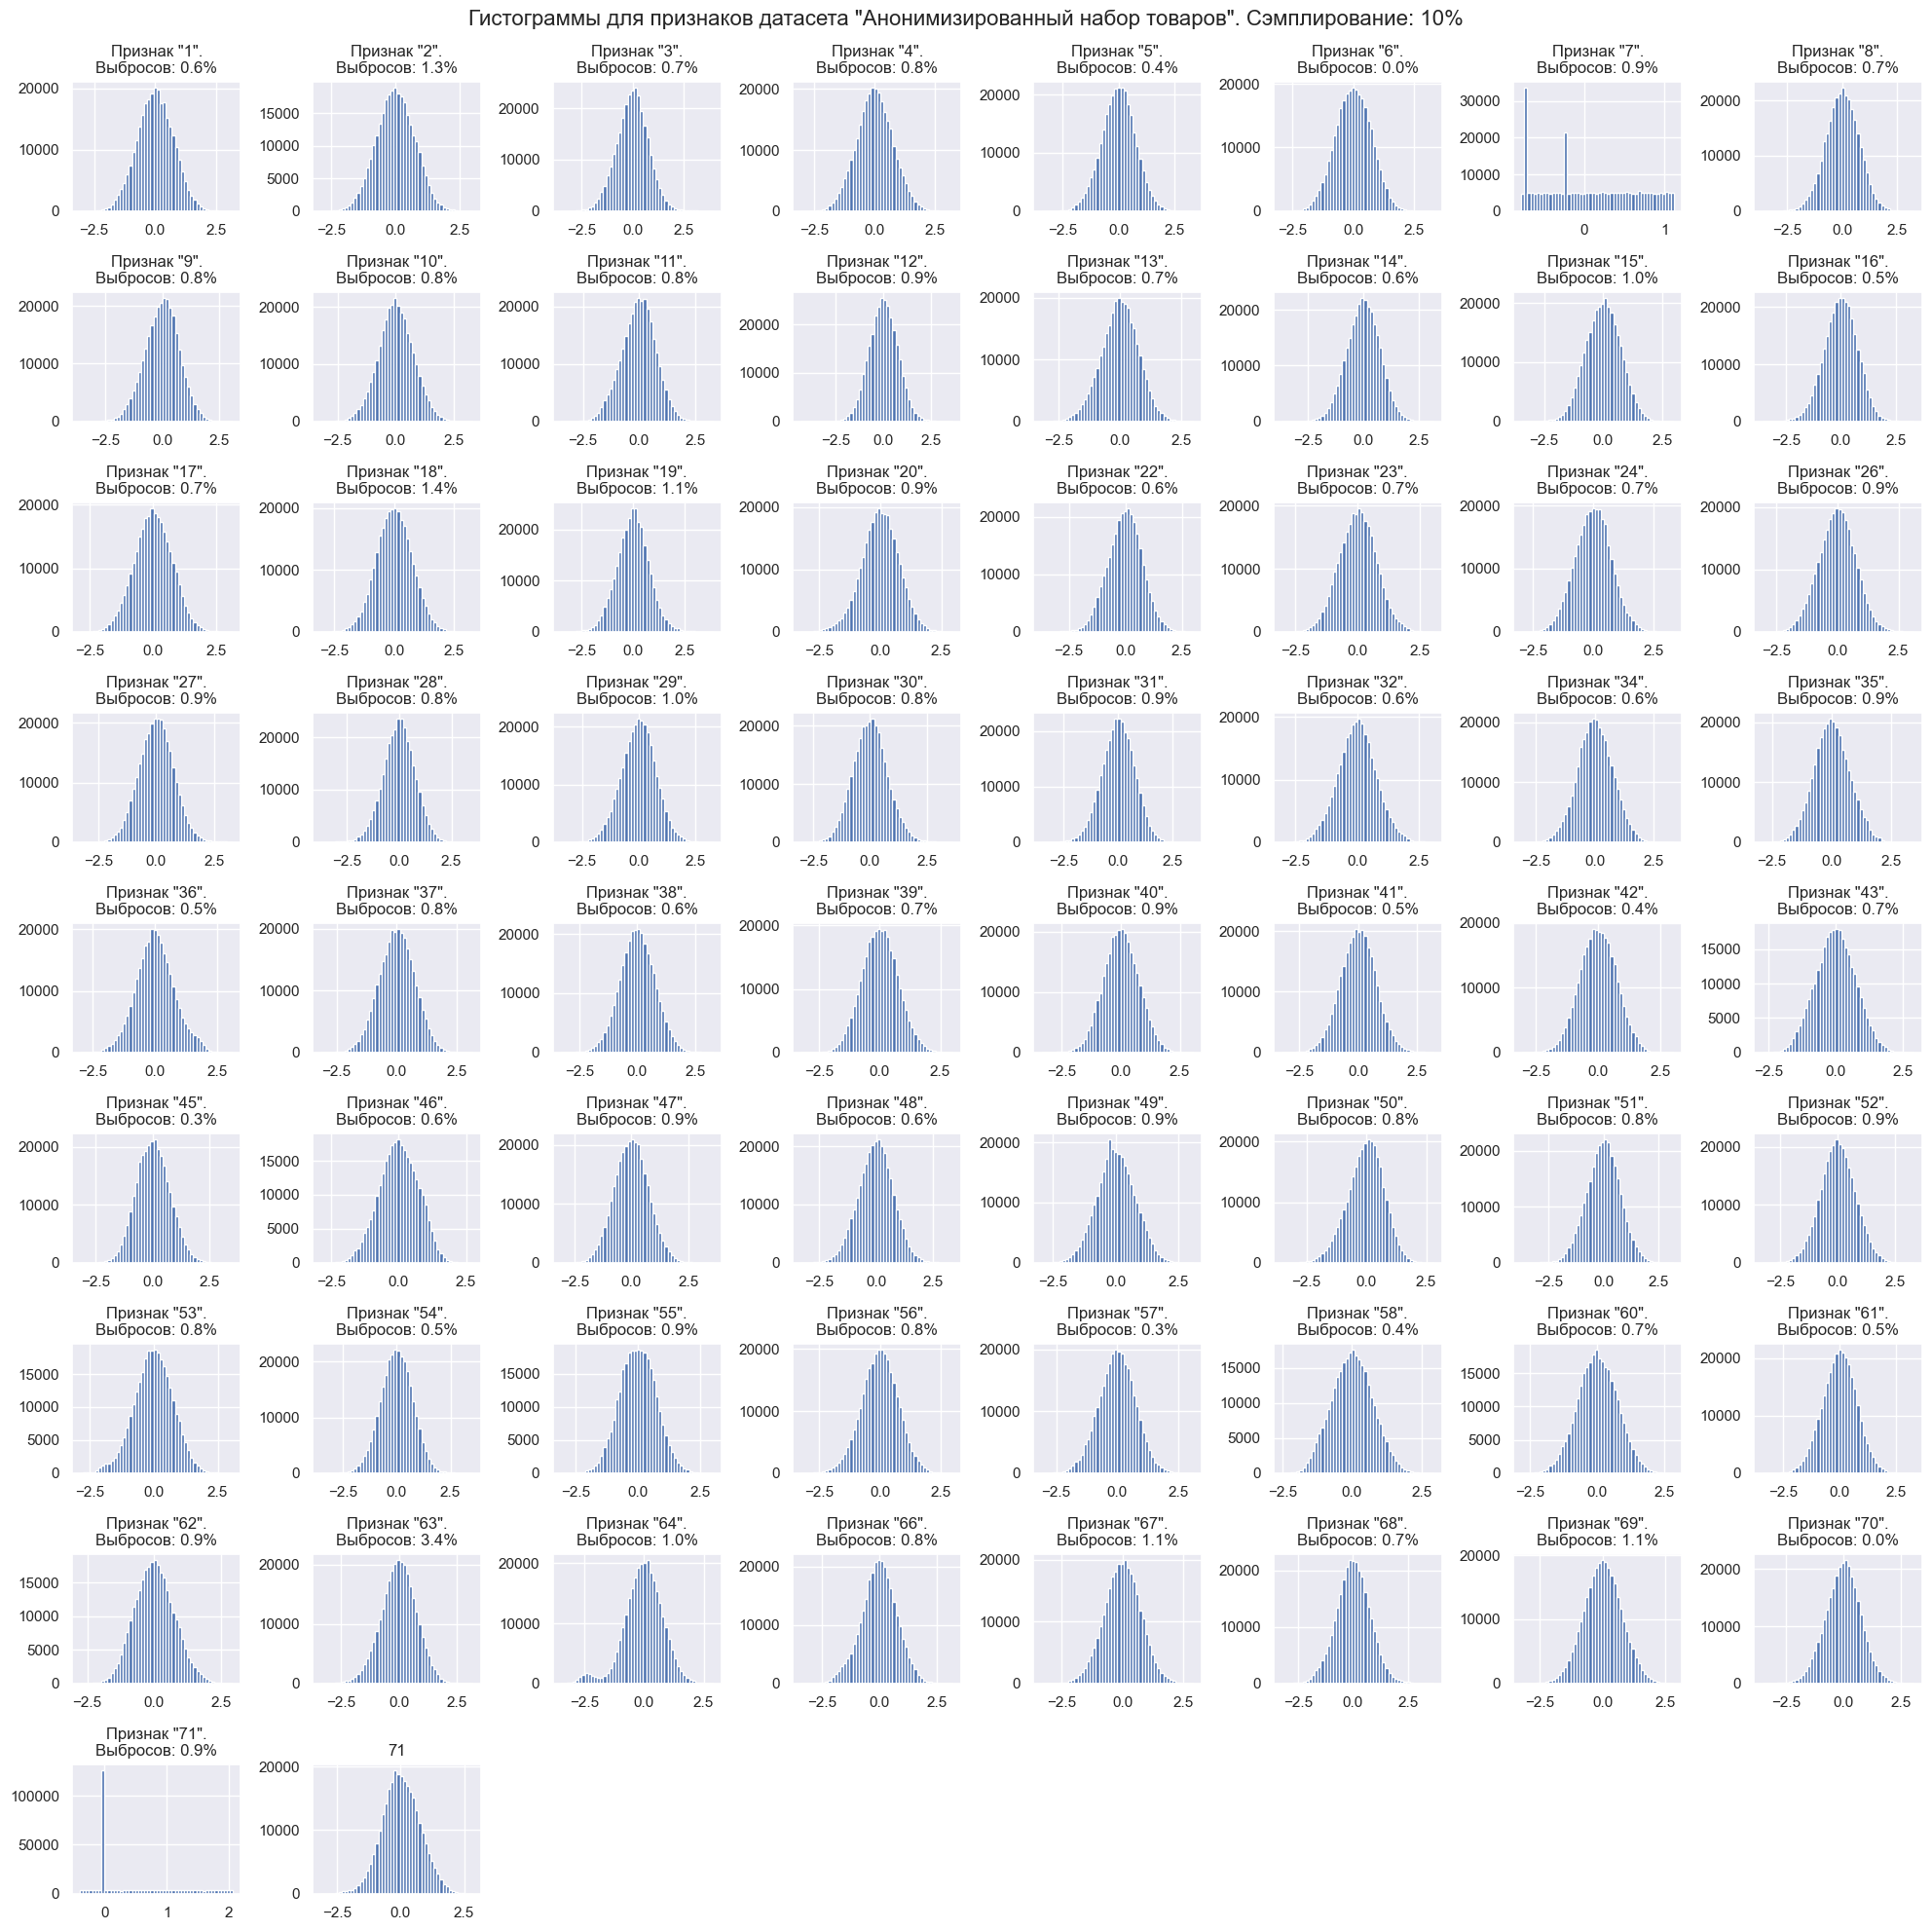

In [26]:
project.hist_diagrams(dataset_name='base', frac=0.1)

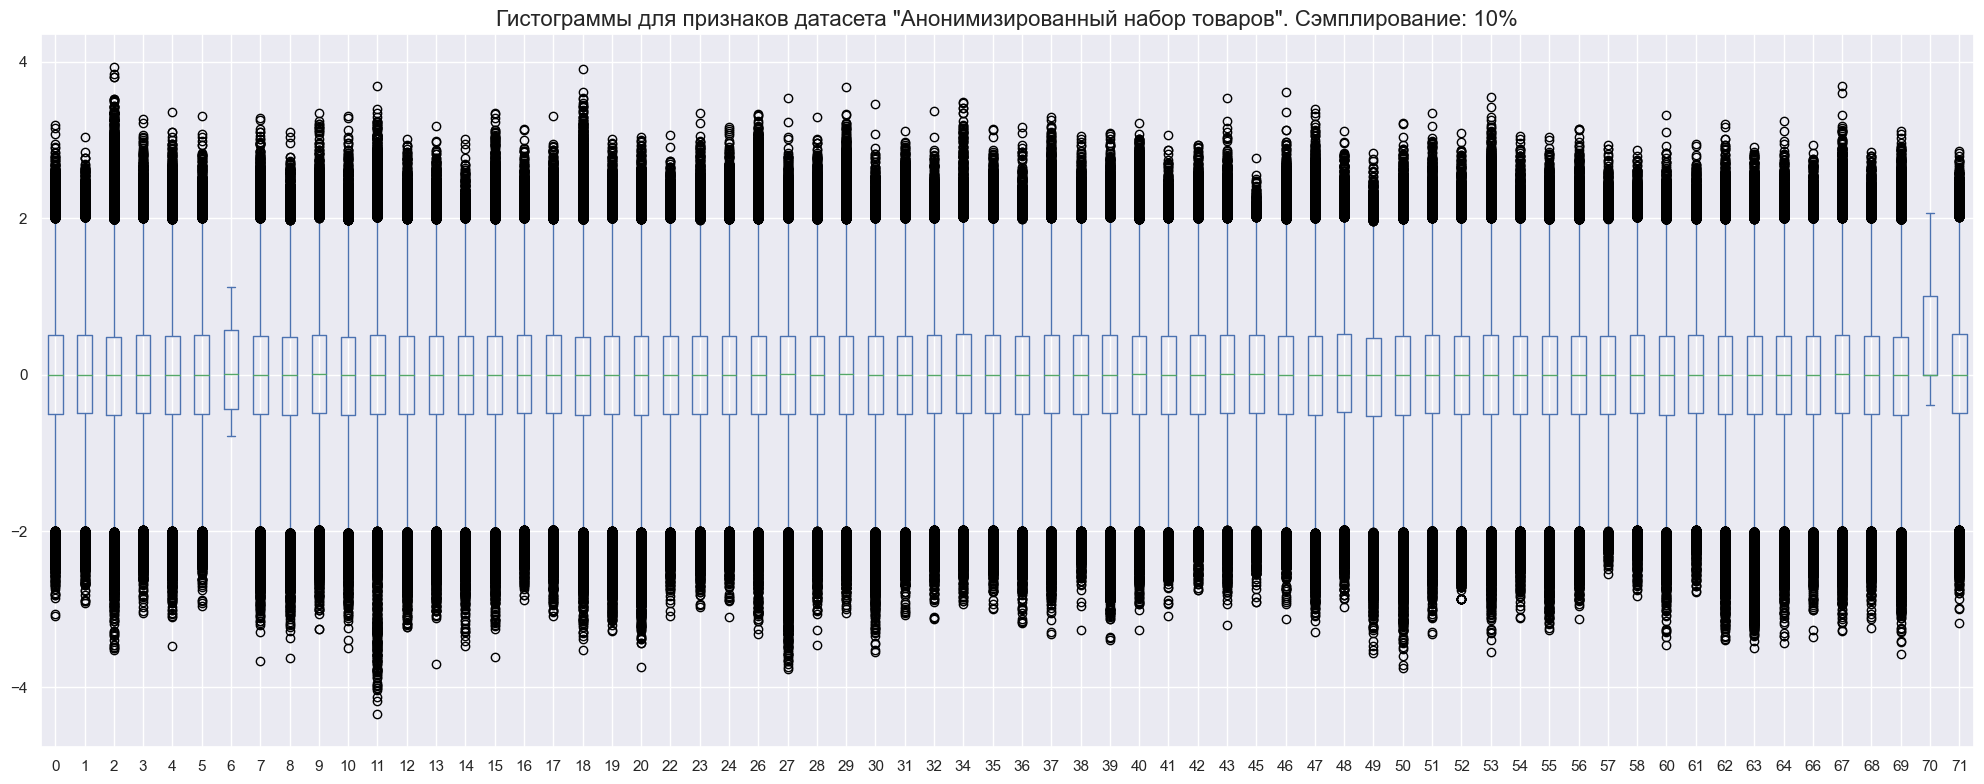

In [27]:
project.range_diagrams(dataset_name='base', frac=0.1)

- Качество, распределения и аномалии если и изменились, то несущественно – на первый взгляд все нормально
- Можно тестировать модели на масштабированных данных

### Тестирование на масштабированных данных

In [28]:
%%time
time, accuracy = modeling.faiss_metric( clusters_num=FAISS_CLUSTERS_NUM)
print('Метрика "эвклидово расстояние". faiss-index = "ivf-flat"')
print(f'Время: {time}')
print(f'accuracy@5: {accuracy}')

print()

time, accuracy  = modeling.faiss_metric(index_mode='ivf_hnsw', clusters_num=FAISS_CLUSTERS_NUM)
print('Метрика "эвклидово расстояние". faiss-index = "ivf_hnsw"')
print(f'Время: {time}')
print(f'accuracy@5: {accuracy}')

Метрика "эвклидово расстояние". faiss-index = "ivf-flat"
Время: 13.805
accuracy@5: 67.704

Метрика "эвклидово расстояние". faiss-index = "ivf_hnsw"
Время: 596.428
accuracy@5: 78.978
CPU times: user 1h 36min 38s, sys: 14.6 s, total: 1h 36min 53s
Wall time: 10min 13s


Метрика "эвклидово расстояние". faiss-index = "ivf_hnsw"
Время: 595.671
accuracy@5: 78.978
CPU times: user 1h 34min 38s, sys: 13.4 s, total: 1h 34min 51s
Wall time: 9min 57s


### Выводы по моделированию

- В результате масштабирования и удаления аномальных признаков из датасетов, мы получили кратное увеличение метрики accuracy@5 для FAISS с индексом "ivf_hnsw"
- Можно переходить к проверке качества поиска

Лучший результат:

Метрика "эвклидово расстояние". faiss-index = "ivf_hnsw"

Время: 596.428

accuracy@5: 78.978

## Ранжирование

In [30]:
class Ranging:

    project: None
    modeling: None

    df_idx = None
    
    samples_merged = {}

    features = {}
    targets = {}

    def __init__(self, project, modeling):
        self.project = project
        self.modeling = modeling

    # Подготовка датафрейма с индексами объектов (новые+старые индексы)
    def prepare_idx(self, dataset_name='train'):
        sample_class = self.project.get_dataset(dataset_name)
        df_sample = sample_class.get_df()
        
        df_idx = pd.DataFrame(data=modeling.best_idx[dataset_name], index=df_sample.index)
        df_idx = pd.melt(df_idx.T)

        df_idx.columns = ['id_query', 'candidate']
        df_idx['id_candidate'] = [modeling.base_index[number] for number in df_idx['candidate'].values]
        df_idx.drop('candidate', axis=1, inplace=True)
        self.df_idx = df_idx

        display(df_idx)

    # Слияние датафреймов по id
    def merge_base_train(self, dataset_name='train'):
        dataset_class = self.project.get_dataset('base')
        df = dataset_class.get_df()
        
        sample_class = self.project.get_dataset(dataset_name)
        df_sample = sample_class.get_df()
        target_sample = sample_class.get_target()

        if dataset_name == 'validation':
            va_class = self.project.get_dataset('validation_answer')
            target_sample = va_class.get_df()

        df_merged = self.df_idx.merge(df_sample, left_on='id_query', right_on='id', how='left')
        df_merged = df_merged.merge(df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
        df_merged = df_merged.merge(target_sample, left_on='id_query', right_on='id', how='left')

        self.samples_merged[dataset_name] = df_merged

        display(self.samples_merged[dataset_name].head())
        
        # display(df_merged)

    # Установка бинарного целевого признака
    def set_binary_target(self, dataset_name='train', target_field_name='target'):
        self.samples_merged[dataset_name]['binary_target'] = (self.samples_merged[dataset_name]['id_candidate'] == self.samples_merged[dataset_name][target_field_name]).astype('int')
        display(self.samples_merged[dataset_name][['id_query', 'id_candidate', target_field_name, 'binary_target']])
        self.samples_merged[dataset_name].drop(target_field_name, axis=1, inplace=True)

    # Разделение на features/target
    def split_features_target(self, dataset_name='train'):
        self.targets[dataset_name] = self.samples_merged[dataset_name]['binary_target']
        self.features[dataset_name] = self.samples_merged[dataset_name].drop(['id_query', 'id_candidate', 'binary_target'] , axis=1)

        display(self.targets[dataset_name].to_frame())
        display(self.features[dataset_name])

    # Сохранение выборок для более удобной дальнейшей работы и очищения памяти
    def save_samples(self, dataset_names):
        for dataset_name in dataset_names:
            
            features_filename = f'data/X_{dataset_name}.csv'
            target_filename = f'data/y_{dataset_name}.csv'
            
            features = self.features[dataset_name]
            target = self.targets[dataset_name]
            
            features.to_csv(features_filename, index=False)
            target.to_csv(target_filename, index=False)

            if dataset_name == 'validation':
                va_class = self.project.get_dataset('validation_answer')
                valid_targets = va_class.get_df()
                valid_targets.to_csv('data/valid_targets.csv', index=False)

                self.samples_merged[dataset_name].to_csv('data/valid_base_df.csv', index=False)
            
        # del [self.df_idx, self.features, self.targets]
        gc.collect()
            


        

ranging = Ranging(project, modeling)

### Формирование тренировочной выборки

#### Подготовка датафрейма с индексами объектов (новые+старые индексы)

In [31]:
ranging.prepare_idx()

id_query  id_candidate
0            0-query   361564-base
1            0-query  1375561-base
2            0-query  2515747-base
3            0-query   675816-base
4            0-query    91611-base
...              ...           ...
3999995  99999-query  1255868-base
3999996  99999-query   126645-base
3999997  99999-query  4504874-base
3999998  99999-query  2441327-base
3999999  99999-query   382474-base

[4000000 rows x 2 columns]

#### Слияние датафреймов по id

In [32]:
ranging.merge_base_train()

id_query  id_candidate         0         1         2         3         4  \
0  0-query   361564-base  0.956813  1.468961  0.034035 -1.398175  1.222708   
1  0-query  1375561-base  0.956813  1.468961  0.034035 -1.398175  1.222708   
2  0-query  2515747-base  0.956813  1.468961  0.034035 -1.398175  1.222708   
3  0-query   675816-base  0.956813  1.468961  0.034035 -1.398175  1.222708   
4  0-query    91611-base  0.956813  1.468961  0.034035 -1.398175  1.222708   

          5         6         7  ...   62_base   63_base   64_base   66_base  \
0 -0.390937  0.158339  0.203191  ... -0.264746  1.374936 -0.300367 -0.829637   
1 -0.390937  0.158339  0.203191  ... -0.674308  1.355607 -0.201995 -0.743913   
2 -0.390937  0.158339  0.203191  ... -0.523257  0.930395 -0.318859 -0.784439   
3 -0.390937  0.158339  0.203191  ... -0.715156  1.296441  0.040938 -0.379632   
4 -0.390937  0.158339  0.203191  ... -0.144660  1.463011 -0.414776 -0.863758   

    67_base   68_base   69_base   70_base   71_base       target  
0  0.216890 -0.367293  0.387914  0.852135  0.081671  675816-base  
1  0.008687 -0.354664  0.347865  0.474878  0.291492  675816-base  
2  0.060616 -0.264105  0.514038  0.000000  0.700775  675816-base  
3  0.304065 -0.424276  0.034364  1.158240  0.543249  675816-base  
4  0.400282 -0.267430  0.633551  1.452223  0.278423  675816-base  

[5 rows x 135 columns]

#### Установка бинарного целевого признака

In [33]:
ranging.set_binary_target()

id_query  id_candidate        target  binary_target
0            0-query   361564-base   675816-base              0
1            0-query  1375561-base   675816-base              0
2            0-query  2515747-base   675816-base              0
3            0-query   675816-base   675816-base              1
4            0-query    91611-base   675816-base              0
...              ...           ...           ...            ...
3999995  99999-query  1255868-base  2769109-base              0
3999996  99999-query   126645-base  2769109-base              0
3999997  99999-query  4504874-base  2769109-base              0
3999998  99999-query  2441327-base  2769109-base              0
3999999  99999-query   382474-base  2769109-base              0

[4000000 rows x 4 columns]

#### Разделение на features/target

In [34]:
ranging.split_features_target()

binary_target
0                    0
1                    0
2                    0
3                    1
4                    0
...                ...
3999995              0
3999996              0
3999997              0
3999998              0
3999999              0

[4000000 rows x 1 columns]

0         1         2         3         4         5         6  \
0        0.956813  1.468961  0.034035 -1.398175  1.222708 -0.390937  0.158339   
1        0.956813  1.468961  0.034035 -1.398175  1.222708 -0.390937  0.158339   
2        0.956813  1.468961  0.034035 -1.398175  1.222708 -0.390937  0.158339   
3        0.956813  1.468961  0.034035 -1.398175  1.222708 -0.390937  0.158339   
4        0.956813  1.468961  0.034035 -1.398175  1.222708 -0.390937  0.158339   
...           ...       ...       ...       ...       ...       ...       ...   
3999995 -0.083320  0.428842 -0.188039  0.097384  0.510331 -0.379105  0.724015   
3999996 -0.083320  0.428842 -0.188039  0.097384  0.510331 -0.379105  0.724015   
3999997 -0.083320  0.428842 -0.188039  0.097384  0.510331 -0.379105  0.724015   
3999998 -0.083320  0.428842 -0.188039  0.097384  0.510331 -0.379105  0.724015   
3999999 -0.083320  0.428842 -0.188039  0.097384  0.510331 -0.379105  0.724015   

                7         8         9  ...   61_base   62_base   63_base  \
0        0.203191 -1.744734 -1.089301  ...  0.173814 -0.264746  1.374936   
1        0.203191 -1.744734 -1.089301  ...  0.121216 -0.674308  1.355607   
2        0.203191 -1.744734 -1.089301  ... -0.145020 -0.523257  0.930395   
3        0.203191 -1.744734 -1.089301  ... -0.415762 -0.715156  1.296441   
4        0.203191 -1.744734 -1.089301  ...  0.115329 -0.144660  1.463011   
...           ...       ...       ...  ...       ...       ...       ...   
3999995  0.654992 -0.700267 -0.587460  ... -1.243768 -0.094766  0.389962   
3999996  0.654992 -0.700267 -0.587460  ... -1.894724 -0.393724 -1.401061   
3999997  0.654992 -0.700267 -0.587460  ... -0.639010 -0.896155 -1.761610   
3999998  0.654992 -0.700267 -0.587460  ... -0.659959 -0.366825 -0.761986   
3999999  0.654992 -0.700267 -0.587460  ... -0.983897 -0.968058 -0.883737   

          64_base   66_base   67_base   68_base   69_base   70_base   71_base  
0       -0.300367 -0.829637  0.216890 -0.367293  0.387914  0.852135  0.081671  
1       -0.201995 -0.743913  0.008687 -0.354664  0.347865  0.474878  0.291492  
2       -0.318859 -0.784439  0.060616 -0.264105  0.514038  0.000000  0.700775  
3        0.040938 -0.379632  0.304065 -0.424276  0.034364  1.158240  0.543249  
4       -0.414776 -0.863758  0.400282 -0.267430  0.633551  1.452223  0.278423  
...           ...       ...       ...       ...       ...       ...       ...  
3999995 -0.263192  0.182226 -0.548788 -0.453671  0.124258  0.841080 -1.095737  
3999996  1.178245 -1.039496  0.448647  0.491461 -0.942976 -0.097252 -0.467749  
3999997 -0.476605  0.074182  0.689391  1.676750  0.094724  1.094751 -0.137916  
3999998  0.113828 -0.307846  1.060992  0.417236  0.436999  0.000000 -0.565840  
3999999  0.207989 -0.370657  0.581219  0.122874  0.495481  1.292348 -0.603491  

[4000000 rows x 132 columns]

### Формирование валидационной выборки

#### Поиск в индексе

In [35]:
valid_dataset_class = project.get_dataset('validation')
df_valid = valid_dataset_class.get_df()

valid_idx = np.ascontiguousarray(df_valid.values)
modeling.faiss_search(valid_idx, dataset_name='validation')

#### Подготовка датафрейма с индексами объектов (новые+старые индексы)

In [36]:
ranging.prepare_idx(dataset_name='validation')

id_query  id_candidate
0        100000-query  2760762-base
1        100000-query  3209652-base
2        100000-query  3839597-base
3        100000-query   368296-base
4        100000-query  1542803-base
...               ...           ...
3999995  199999-query  2819529-base
3999996  199999-query  2227997-base
3999997  199999-query    84881-base
3999998  199999-query   170318-base
3999999  199999-query  1849089-base

[4000000 rows x 2 columns]

#### Слияние датафреймов по id

In [37]:
ranging.merge_base_train(dataset_name='validation')

id_query  id_candidate         0         1         2         3  \
0  100000-query  2760762-base  0.853586 -0.656829  0.612866  0.784502   
1  100000-query  3209652-base  0.853586 -0.656829  0.612866  0.784502   
2  100000-query  3839597-base  0.853586 -0.656829  0.612866  0.784502   
3  100000-query   368296-base  0.853586 -0.656829  0.612866  0.784502   
4  100000-query  1542803-base  0.853586 -0.656829  0.612866  0.784502   

          4         5         6         7  ...   62_base   63_base   64_base  \
0 -0.018218 -0.240307 -0.082091  1.381604  ... -0.059688  0.033002  0.021391   
1 -0.018218 -0.240307 -0.082091  1.381604  ...  0.333063  0.738906  0.425058   
2 -0.018218 -0.240307 -0.082091  1.381604  ...  0.174123  0.461095 -0.210524   
3 -0.018218 -0.240307 -0.082091  1.381604  ... -0.185964 -0.030613  0.666620   
4 -0.018218 -0.240307 -0.082091  1.381604  ...  0.071744  0.243595  0.133582   

    66_base   67_base   68_base   69_base   70_base   71_base      expected  
0  0.388704  0.896480 -0.078051  0.106997  0.479721 -0.914710  2676668-base  
1  0.668970  0.689179  0.014489  0.310670  0.000000 -0.868064  2676668-base  
2  0.463157  0.438973 -0.023346  0.461295  0.000000 -0.877913  2676668-base  
3  0.360188  0.433430  0.127743 -0.263147 -0.228781 -0.804465  2676668-base  
4  0.528651  0.469607 -0.119730  0.369001  0.904144 -0.750859  2676668-base  

[5 rows x 135 columns]

#### Установка бинарного целевого признака

In [38]:
ranging.set_binary_target(dataset_name='validation', target_field_name='expected')

id_query  id_candidate      expected  binary_target
0        100000-query  2760762-base  2676668-base              0
1        100000-query  3209652-base  2676668-base              0
2        100000-query  3839597-base  2676668-base              0
3        100000-query   368296-base  2676668-base              0
4        100000-query  1542803-base  2676668-base              0
...               ...           ...           ...            ...
3999995  199999-query  2819529-base   336472-base              0
3999996  199999-query  2227997-base   336472-base              0
3999997  199999-query    84881-base   336472-base              0
3999998  199999-query   170318-base   336472-base              0
3999999  199999-query  1849089-base   336472-base              0

[4000000 rows x 4 columns]

#### Разделение на features/target

In [39]:
ranging.split_features_target(dataset_name='validation')

binary_target
0                    0
1                    0
2                    0
3                    0
4                    0
...                ...
3999995              0
3999996              0
3999997              0
3999998              0
3999999              0

[4000000 rows x 1 columns]

0         1         2         3         4         5         6  \
0        0.853586 -0.656829  0.612866  0.784502 -0.018218 -0.240307 -0.082091   
1        0.853586 -0.656829  0.612866  0.784502 -0.018218 -0.240307 -0.082091   
2        0.853586 -0.656829  0.612866  0.784502 -0.018218 -0.240307 -0.082091   
3        0.853586 -0.656829  0.612866  0.784502 -0.018218 -0.240307 -0.082091   
4        0.853586 -0.656829  0.612866  0.784502 -0.018218 -0.240307 -0.082091   
...           ...       ...       ...       ...       ...       ...       ...   
3999995  1.345030 -0.178396  0.276827 -0.358665 -0.048915  0.323115 -0.382792   
3999996  1.345030 -0.178396  0.276827 -0.358665 -0.048915  0.323115 -0.382792   
3999997  1.345030 -0.178396  0.276827 -0.358665 -0.048915  0.323115 -0.382792   
3999998  1.345030 -0.178396  0.276827 -0.358665 -0.048915  0.323115 -0.382792   
3999999  1.345030 -0.178396  0.276827 -0.358665 -0.048915  0.323115 -0.382792   

                7         8         9  ...   61_base   62_base   63_base  \
0        1.381604 -1.297504 -0.565011  ... -1.134930 -0.059688  0.033002   
1        1.381604 -1.297504 -0.565011  ... -1.391391  0.333063  0.738906   
2        1.381604 -1.297504 -0.565011  ... -1.427536  0.174123  0.461095   
3        1.381604 -1.297504 -0.565011  ... -1.182083 -0.185964 -0.030613   
4        1.381604 -1.297504 -0.565011  ... -1.107061  0.071744  0.243595   
...           ...       ...       ...  ...       ...       ...       ...   
3999995 -0.734725 -0.518630 -0.812421  ...  0.212261 -0.171809  0.130047   
3999996 -0.734725 -0.518630 -0.812421  ... -0.456020 -0.238711 -0.275745   
3999997 -0.734725 -0.518630 -0.812421  ...  0.218460 -0.536627 -0.177865   
3999998 -0.734725 -0.518630 -0.812421  ...  0.492766 -0.245096 -0.272348   
3999999 -0.734725 -0.518630 -0.812421  ...  0.029763 -0.256077 -0.185950   

          64_base   66_base   67_base   68_base   69_base   70_base   71_base  
0        0.021391  0.388704  0.896480 -0.078051  0.106997  0.479721 -0.914710  
1        0.425058  0.668970  0.689179  0.014489  0.310670  0.000000 -0.868064  
2       -0.210524  0.463157  0.438973 -0.023346  0.461295  0.000000 -0.877913  
3        0.666620  0.360188  0.433430  0.127743 -0.263147 -0.228781 -0.804465  
4        0.133582  0.528651  0.469607 -0.119730  0.369001  0.904144 -0.750859  
...           ...       ...       ...       ...       ...       ...       ...  
3999995 -0.057259 -0.846876 -0.419102  0.534735  1.006343 -0.109395 -0.455608  
3999996  0.124579 -0.187214 -0.306199  0.037884  0.405506  0.000000 -0.601711  
3999997 -0.245169 -0.646522 -0.451815  0.564110  1.085896  1.600252 -0.583774  
3999998 -0.516066 -0.529755 -0.518614  0.752741  1.028584  0.000000 -0.187120  
3999999 -0.594248 -0.679529 -0.555061  0.153850  0.911535  1.677850 -0.605756  

[4000000 rows x 132 columns]

В результате получились датасеты для обучения и валидации модели

### Сохраним тренировочную и валидационную выборки

In [40]:
ranging.save_samples(dataset_names=['train', 'validation'])

## Тестирование на модели Random Forest

Данную модель для классификации я выбрал потому, что хорошо с ней поработал в предыдущих проектах и она показала неплохие результаты

### Загружаем выборки признаков и целевых признаков

In [41]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
X_valid = pd.read_csv('data/X_validation.csv')
y_valid = pd.read_csv('data/y_validation.csv')

targets_df = pd.read_csv('data/valid_targets.csv')
valids_df = pd.read_csv('data/valid_base_df.csv')

### Обучаем модель

(гиперпараметры я взял из одного из своих прошлых проектов)

In [42]:
%%time
model = RandomForestClassifier(
    n_estimators=100,
    max_leaf_nodes=8,
    min_samples_split=2,
    criterion='gini',
    max_depth=12,
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)

CPU times: user 17min 50s, sys: 10.5 s, total: 18min 1s
Wall time: 18min 1s


RandomForestClassifier(max_depth=12, max_leaf_nodes=8, random_state=12345)

### Делаем предсказания

In [43]:
prediction = model.predict(X_valid)
probabilities = model.predict_proba(X_valid)[:, 1]

### Метрика "Accuracy Score"

In [44]:
accuracy = accuracy_score(y_valid, prediction)
print(f'{COLOR_BOLD}Accuracy score:{COLOR_END} {accuracy}')

Accuracy score: 0.98027725


Значение метрики на высочайшем уровне, что говорит о хорошо проведенном поиске

Результат: Accuracy score: 0.98027725

### AUC_ROC Кривая

In [45]:
auc_roc = roc_auc_score(y_valid, probabilities)
print(f'{COLOR_BOLD}AUC-ROC score:{COLOR_END} {auc_roc}')

AUC-ROC score: 0.7312962833993543


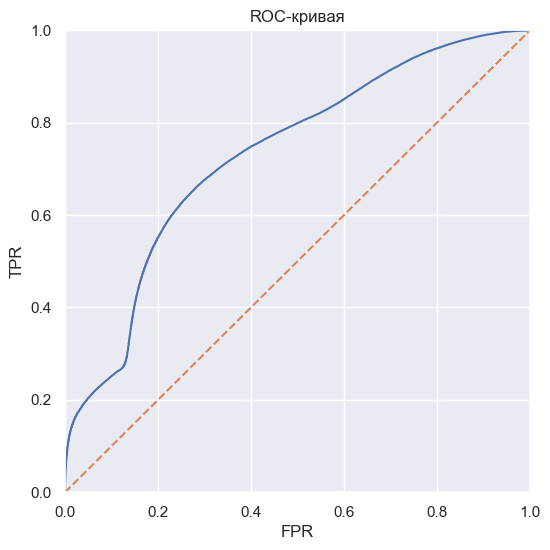

In [46]:
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)

plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Метрика AUC-ROC находится на достаточно высоком уровне, что говорит о том, что модель бинарной классификации очень качественная

### Сколько предсказаний сделали и сколько кандидатов найдено

In [47]:
proba_series = pd.Series(probabilities)

candidates = []
for i in range(0, len(proba_series), K_N):
    query = proba_series[i : i+K_N]
    index = query.sort_values(ascending=False)[0:CANDIDATES_NUM].index
    candidates.append(index)
    
print(f'Кол-во предсказаний:{COLOR_END}', len(candidates))
print(f'Кол-во кандидатов:{COLOR_END}', len(candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


### Финальное вычисление метрики accuracy@5

In [48]:

acc = 0
for target, cands in zip(targets_df.values.tolist(), candidates):
    acc += int(target in valids_df.loc[cands, 'id_candidate'].values)

print('accuracy@{}: {:.2f}%'.format(CANDIDATES_NUM, acc / len(candidates) * 100))

accuracy@5: 38.73%


Финальная метрика accuracy@5: 38.73%
Это нелохой результат, но можно постараться его улучшить. О чем я расскажу в нце работы

In [49]:
gc.collect()

0

# Заключение

## Общий вывод

В результате исследования:

- Были загружены данные
- Проведен EDA и подготовлены данные
- Проверены несколько библиотке для поиска похожих векторов:
- Также были проверены некоторые параметры для лучших результатов
- Проведен финальный поиск на полных и отмасштабированых данных
- Финальный поиск протестирован c помощью классификатора __RandomForestClassifier__ и получены высокие метрики accuracy@5, accuracy_score и AUC-ROC
- Уложились в 1000 секунд при поиске

__модель готова к дальнейшей работе и использованию в реальных задачах__

### Рекомендации по улучшению

- Провести исследование на дисбаланс классов
- Проверить такие методы как KMeans + NearestNeighbors и другие (но KMeans + NearestNeighbors, судя по всему сразу не даст хорошие результаты и усилий придется приложить больше. Вообще это тема отдельная)
- Попробовать побольше менять гиперпараметры для FAISS
- Проверить качество поиска на других моделях (Linear/Logistic regression)
- Возможно стоит добавить кросс-валидацию
- Оптимизировать код, тк сейчас он потребляет большое количество памяти и времени

__Спасибо за внимание!__